<h1>
    <p style ="font-family:Helvetica;color:#3f5982;font-size:25pt"> Analysing Internet Unconnectedness in the United States </p>
</h1>

<div class="image">
    
      <h4>
          <p style="font-size:18pt;font-family:Helvetica;color:#2b2c2d">BENVGSA6 Data Science for Spatial Systems</p>
          <p style="font-size:16pt;font-family:Helvetica;color:#353638"> Matej Puchovsky (17084573) </p>
          <p style="font-size:16pt;font-family:Helvetica;color:#353638"> University College London</p>
          <p style="font-size:14pt;color:#353638;text-align:right">April 2018 </p>
      </h4>

</div>

<div style="font-family:Helvetica;background-color:#3f5982">
<h1 ><font color="White">Introduction</font></h1>
</div>

The Internet plays a vital role in lives of modern individuals. Using the Internet has enabled us access to information far faster and has allowed us to stay connected to the world and communicate with each other easier. Furthermore, it has helped create numerous jobs and new creative industries, with the United being among the first adopters of digital technology (in 1984, <a href="https://www.census.gov/hhes/computer/files/1984/p23-155.pdf">8.2%</a> of all US households owned a PC).

Over the years, the number of individuals using the Internet (as % of population) in the US <a href="https://data.worldbank.org/indicator/IT.NET.USER.ZS?end=2016&locations=US&start=1990&view=chart&year_low_desc=true">grew consistenly</a> between and 2007 (from only 0.79% to 75%). However, in last ten years, only marginal increase in Internet adoption across has been recorded with around one-quarter of Americans still having no access to the Internet in 2016, leaving the US behind most countries of the developed world. As discussed <a href="https://www.ntia.doc.gov/blog/2016/digitally-unconnected-us-who-s-not-online-and-whyin">in a study</a> conducted by the National Telecommunications and Information Administration (US Department of Commerce) in 2015, people with disabilities, those with lower incomes and lower levels of educational attainment were among the groups most likely not to use the Internet at home. Lacking interest in the technology, high cost or lacking a working computer remain the top reasons of households for remaining digitally unconnected. According to <a href="http://www.pewresearch.org/fact-tank/2018/03/05/some-americans-dont-use-the-internet-who-are-they/">another survey</a> from the Pew Research Center also find that older people as well as the rural population exhibit a significantly lower Internet adoption compared to younger generations or those living in urban areas respectively. Additionally, they also name income and education as relevant factors.

The goal of this study is to provide further insights into the issue of digital unconnectedness in the US with focus on regional differences across the country. For this purpose, a comprehensive dataset compiled from a 2016 1-year estimate of the <a href="https://www.census.gov/programs-surveys/acs/">*American Community Survey (ACS)*</a>, combined with additional socio-demographic data from the <a href="https://factfinder.census.gov">*American FactFinder*</a>, is analysed. The main dataset (with data about counties with population over 65,000) used for this project can be downloaded from <a href="https://www.kaggle.com/madaha/people-without-internet/data">kaggle</a>.

This notebook is structured as follows:
The first part describes the data preprocessing and manipulation phase. This is followed by exploratory analysis with a number of descriptive statistics and relevant geographical and socio-demographical insights. Finally, the last part introduces a linear as well as a logistic regression model to accurately find and predict those communities above the national median of digital unconnectedness. 

By providing both the descriptive statistics and making predictions about highly-unconnected counties, relevant factors and communities can be targeted. Overall, the results could be used by law-makers in order to create new policies aimed at reducing the number of digitally unconnected in the United States.

<div style="font-family:Helvetica;background-color:#3f5982">
<h1 ><font color="White">Data Preparation</font></h1>
</div>

In [645]:
# The preamble
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as scipy
from scipy import stats
import collections
import operator
import os
from folium.plugins import HeatMap
import folium
import sklearn
from sklearn.utils import resample
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import RFE
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
from functools import reduce
import geopandas as gp
import shapely
import pandas.tseries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFECV
import plotly.graph_objs as go
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib as mpl
mpl.style.use('default')
%matplotlib inline

In [646]:
# Importing the main datafile (Source: https://www.kaggle.com/madaha/people-without-internet)
data = pd.read_csv("kaggle_internet.csv")

In [647]:
# Peak at the data
data.head()

,county,state,GEOID,lon,lat,P_total,P_white,P_black,P_asian,P_native,P_hawaiian,P_others,P_below_middle_school,P_some_high_school,P_high_school_equivalent,P_some_college,P_bachelor_and_above,P_below_poverty,median_age,gini_index,median_household_income,median_rent_per_income,percent_no_internet
0,Anchorage Municipality,AK,05000US02020,-149.274354,61.177549,298192,184841.0,16102.0,27142.0,23916.0,7669.0,7935.0,2234.0,8196.0,44804.0,66162.0,70713.0,18302,33.0,0.4018,85634,28.0,6.593887
1,Fairbanks North Star Borough,AK,05000US02090,-146.599867,64.690832,100605,75501.0,4385.0,3875.0,7427.0,503.0,2357.0,924.0,1527.0,14725.0,24570.0,19257.0,9580,30.6,0.3756,77328,25.6,12.102458
2,Matanuska-Susitna Borough,AK,05000US02170,-149.407974,62.182173,104365,86314.0,1019.0,1083.0,5455.0,141.0,325.0,337.0,2755.0,21071.0,28472.0,12841.0,9893,34.2,0.4351,69332,29.6,11.156575
3,Baldwin County,AL,05000US01003,-87.746067,30.659218,208563,180484.0,18821.0,914.0,1383.0,0.0,1469.0,3245.0,10506.0,41822.0,46790.0,43547.0,23375,42.4,0.4498,56732,29.3,17.868167
4,Calhoun County,AL,05000US01015,-85.822513,33.771706,114611,NaN,NaN,NaN,NaN,NaN,NaN,2455.0,8853.0,24761.0,26625.0,12909.0,18193,39.1,0.4692,41687,24.8,23.464932


In [648]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820 entries, 0 to 819
Data columns (total 23 columns):
county                      820 non-null object
state                       820 non-null object
GEOID                       820 non-null object
lon                         820 non-null float64
lat                         820 non-null float64
P_total                     820 non-null int64
P_white                     607 non-null float64
P_black                     607 non-null float64
P_asian                     607 non-null float64
P_native                    607 non-null float64
P_hawaiian                  607 non-null float64
P_others                    607 non-null float64
P_below_middle_school       818 non-null float64
P_some_high_school          818 non-null float64
P_high_school_equivalent    818 non-null float64
P_some_college              818 non-null float64
P_bachelor_and_above        818 non-null float64
P_below_poverty             820 non-null int64
median_age          

The original dataset only contains geo-ids of the counties, their names as well as the respective state codes. By importing the following dataset, we can introduce new regional distinctions of the counties (e.g. West, South, Midwest):

In [649]:
states_regions_divisions = pd.read_csv("https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv")
states_regions_divisions.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [650]:
# Adding regions to the main dataframe
states_regions_divisions.columns = ['state_name','state_code','region','division']
data = data.rename(columns={'state': 'state_code'})
data = pd.merge(data, states_regions_divisions, on='state_code')

In order to provide for a more detailed analysis about the digitally unconnected, following additional socio-demographic attributes about the 820 US counties in the scope of this study were added to the original dataset:

- disability (share of peole with disability)
- nativity status (native/foreign-born population)
- employment status (employment & unemployment rate)
- sex (male-female ratio)

These additional files containing 2016 ACS 1-year estimate data were downloaded from the <a href="https://factfinder.census.gov">American FactFinder</a> (US Census Bureau).

In [651]:
disability = pd.read_csv("disability.csv", encoding='latin-1')
native_foreign = pd.read_csv("native_foreign.csv", encoding='latin-1')
employment = pd.read_csv("employment.csv", encoding='latin-1')
sex = pd.read_csv("sex_age.csv", encoding='latin-1')

In [652]:
# Scaling the share of disabled to a 0-1 scale:
disability['with_disability']=disability['Percent with a disability; Estimate; Total civilian noninstitutionalized population']/100
disability = disability[['Id','with_disability']]
disability.head()

,Id,with_disability
0,0500000US01003,0.149
1,0500000US01015,0.215
2,0500000US01043,0.156
3,0500000US01049,0.129
4,0500000US01051,0.172


In [653]:
# Transforming employment data to a 0-1 scale:
employment[['Employment/Population Ratio; Estimate; Population 16 years and over','Unemployment rate; Estimate; Population 16 years and over']] = employment[['Employment/Population Ratio; Estimate; Population 16 years and over','Unemployment rate; Estimate; Population 16 years and over']].apply(pd.to_numeric, errors='coerce')

employment['employment_rate'] = employment['Employment/Population Ratio; Estimate; Population 16 years and over']/100
employment['unemployment_rate'] = employment['Unemployment rate; Estimate; Population 16 years and over']/100

employment = employment[['Id','employment_rate','unemployment_rate']]
employment.head()

,Id,employment_rate,unemployment_rate
0,0500000US01003,0.536,0.036
1,0500000US01015,0.504,0.093
2,0500000US01043,0.490,0.047
3,0500000US01049,0.527,0.050
4,0500000US01051,0.522,0.049


In [654]:
# Transforming sex data to a 0-1 scale:
sex['male'] = sex['Male; Estimate; Total population'] / sex['Total; Estimate; Total population']
sex['female'] = sex['Female; Estimate; Total population'] / sex['Total; Estimate; Total population']
sex = sex[['Id','male','female']]
sex.head()

,Id,male,female
0,0500000US01003,0.483796,0.516204
1,0500000US01015,0.484168,0.515832
2,0500000US01043,0.493495,0.506505
3,0500000US01049,0.486728,0.513272
4,0500000US01051,0.488466,0.511534


In [655]:
# Transforming nativity status to a 0-1 scale:
native_foreign['native_p_per'] = native_foreign['Estimate; Total: - Native'] / native_foreign['Estimate; Total:']
native_foreign['foreign_born_p_per'] = native_foreign['Estimate; Total: - Foreign-Born'] / native_foreign['Estimate; Total:']

native_foreign = native_foreign[['Id','native_p_per','foreign_born_p_per']]
native_foreign.head()

,Id,native_p_per,foreign_born_p_per
0,0500000US01003,0.978213,0.021787
1,0500000US01015,0.975953,0.024047
2,0500000US01043,0.967758,0.032242
3,0500000US01049,0.945106,0.054894
4,0500000US01051,0.991614,0.008386


Next, the new demographics data can be merged into one dataframe:

In [656]:
demographics = [disability, employment, sex, native_foreign]
demographics_final = reduce(lambda left,right: pd.merge(left,right,on='Id'), demographics)
demographics_final.head()

,Id,with_disability,employment_rate,unemployment_rate,male,female,native_p_per,foreign_born_p_per
0,0500000US01003,0.149,0.536,0.036,0.483796,0.516204,0.978213,0.021787
1,0500000US01015,0.215,0.504,0.093,0.484168,0.515832,0.975953,0.024047
2,0500000US01043,0.156,0.490,0.047,0.493495,0.506505,0.967758,0.032242
3,0500000US01049,0.129,0.527,0.050,0.486728,0.513272,0.945106,0.054894
4,0500000US01051,0.172,0.522,0.049,0.488466,0.511534,0.991614,0.008386


In [657]:
# Creating a unique identifier in the main dataframe in order to merge it with demographics_final
data[['Id', 'Id2']] = data['GEOID'].str.split('05000US', expand=True)
data = data.drop('Id',axis=1)
demographics_final[['Id','Id2']] = demographics_final['Id'].str.split('0500000US', expand=True)
demographics_final = demographics_final.drop('Id',axis=1)
data['Id2'] = data['Id2'].astype(str)
demographics_final['Id2'] = demographics_final['Id2'].astype(str)

Finally, we create a **`master`** dataframe from the original datafame and the newly-added socio-demographic data:

In [658]:
master = pd.merge(data, demographics_final, on='Id2',how="right")
master.head()

,county,state_code,GEOID,lon,lat,P_total,P_white,P_black,P_asian,P_native,P_hawaiian,P_others,P_below_middle_school,P_some_high_school,P_high_school_equivalent,P_some_college,P_bachelor_and_above,P_below_poverty,median_age,gini_index,median_household_income,median_rent_per_income,percent_no_internet,state_name,region,division,Id2,with_disability,employment_rate,unemployment_rate,male,female,native_p_per,foreign_born_p_per
0,Anchorage Municipality,AK,05000US02020,-149.274354,61.177549,298192,184841.0,16102.0,27142.0,23916.0,7669.0,7935.0,2234.0,8196.0,44804.0,66162.0,70713.0,18302,33.0,0.4018,85634,28.0,6.593887,Alaska,West,Pacific,02020,0.119,0.662,0.052,0.512697,0.487303,0.897486,0.102514
1,Fairbanks North Star Borough,AK,05000US02090,-146.599867,64.690832,100605,75501.0,4385.0,3875.0,7427.0,503.0,2357.0,924.0,1527.0,14725.0,24570.0,19257.0,9580,30.6,0.3756,77328,25.6,12.102458,Alaska,West,Pacific,02090,0.097,0.611,0.103,0.553163,0.446837,0.941315,0.058685
2,Matanuska-Susitna Borough,AK,05000US02170,-149.407974,62.182173,104365,86314.0,1019.0,1083.0,5455.0,141.0,325.0,337.0,2755.0,21071.0,28472.0,12841.0,9893,34.2,0.4351,69332,29.6,11.156575,Alaska,West,Pacific,02170,0.128,0.558,0.132,0.519897,0.480103,0.965860,0.034140
3,Baldwin County,AL,05000US01003,-87.746067,30.659218,208563,180484.0,18821.0,914.0,1383.0,0.0,1469.0,3245.0,10506.0,41822.0,46790.0,43547.0,23375,42.4,0.4498,56732,29.3,17.868167,Alabama,South,East South Central,01003,0.149,0.536,0.036,0.483796,0.516204,0.978213,0.021787
4,Calhoun County,AL,05000US01015,-85.822513,33.771706,114611,NaN,NaN,NaN,NaN,NaN,NaN,2455.0,8853.0,24761.0,26625.0,12909.0,18193,39.1,0.4692,41687,24.8,23.464932,Alabama,South,East South Central,01015,0.215,0.504,0.093,0.484168,0.515832,0.975953,0.024047


In [659]:
# Transforming population metrics to a 0-1 scale

# Ethnicity:
master['ethnicity'] = master['P_white']+master['P_black']+master['P_asian']+master['P_native']+master['P_hawaiian']+master['P_others']
master['white_per'] = master['P_white'] / master['ethnicity']
master['black_per'] = master['P_black'] / master['ethnicity']
master['asian_per'] = master['P_asian'] / master['ethnicity']
master['native_per'] = master['P_native'] / master['ethnicity']
master['hawaiian_per'] = master['P_hawaiian'] / master['ethnicity']
master['others_per'] = master['P_others'] / master['ethnicity']

# Education:
master['edu'] = (master['P_below_middle_school'] + master['P_some_high_school'] + 
                 master['P_high_school_equivalent'] + master['P_some_college'] + master['P_bachelor_and_above'])
master['below_middle_school_per'] = master['P_below_middle_school'] / master['edu']
master['some_high_school_per'] = master['P_some_high_school'] / master['edu']
master['high_school_per'] = master['P_high_school_equivalent'] / master['edu']
master['some_college_per'] = master['P_some_college'] / master['edu']
master['bachelor_and_above_per'] = master['P_bachelor_and_above'] / master['edu']

# Poverty line:
master['below_poverty_per'] = master['P_below_poverty']/master['P_total']

At this point, we also transform the data about educational attainment, so that an easier comparison of counties is possible. Here, all five available education levels in the dataset get assigned an ordinal score between 1 and 5:

- 1: below middle school (education at or below 8th grade)
- 2: some high school (some years in high school but without a diploma)
- 3: high school (high school diploma or equivalent)
- 4: some college (associate degree or some years in college without bachelor degree)
- 5: bachelor and above (bachelor, master, professional, or doctor degrees)

These scores are then multiplied with the respective percentages of county population with that specific education attainment level and, subsequently, summed to create a new attribute **`education_level`**. Here, counties with high score are regared as well-educated communities. 

In [660]:
master['education_level'] = ((master['below_middle_school_per']*1)+
                             (master['some_high_school_per']*2)+
                             (master['high_school_per']*3)+
                             (master['some_college_per']*4)+
                             (master['bachelor_and_above_per']*5))

For the sake of consistency, the actual attribute of interest - percentage of people without internet access - is also transformed to a 0-1 scale.

In [661]:
master['percent_no_internet'] = master['percent_no_internet'] / 100

In [662]:
# Summary statistics of the 'master' dataframe
master.describe()

,lon,lat,P_total,P_white,P_black,P_asian,P_native,P_hawaiian,P_others,P_below_middle_school,P_some_high_school,P_high_school_equivalent,P_some_college,P_bachelor_and_above,P_below_poverty,median_age,gini_index,median_household_income,median_rent_per_income,percent_no_internet,with_disability,employment_rate,unemployment_rate,male,female,native_p_per,foreign_born_p_per,ethnicity,white_per,black_per,asian_per,native_per,hawaiian_per,others_per,edu,below_middle_school_per,some_high_school_per,high_school_per,some_college_per,bachelor_and_above_per,below_poverty_per,education_level
count,820.000000,820.000000,8.200000e+02,6.070000e+02,6.070000e+02,6.070000e+02,607.000000,607.000000,6.070000e+02,818.000000,818.000000,8.180000e+02,8.180000e+02,8.180000e+02,8.200000e+02,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,812.000000,812.000000,820.000000,820.000000,820.000000,820.000000,6.070000e+02,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,8.180000e+02,818.000000,818.000000,818.000000,818.000000,818.000000,820.000000,818.000000
mean,-89.828567,38.044369,3.340096e+05,2.886817e+05,5.601865e+04,2.781182e+04,2848.385502,900.958814,2.504326e+04,8811.812958,15426.286064,5.762623e+04,6.489833e+04,7.557799e+04,4.454169e+04,38.662683,0.450951,58111.279268,29.412195,0.152647,0.136462,0.583550,0.057849,0.492811,0.507189,0.918031,0.081969,4.013048e+05,0.793343,0.114772,0.041144,0.012084,0.002261,0.036396,2.223407e+05,0.027324,0.072669,0.293572,0.310229,0.296206,0.133263,3.775325
std,14.975483,5.186474,5.876550e+05,3.905330e+05,1.164917e+05,9.003984e+04,6987.389347,4563.089789,1.073254e+05,32635.312066,31719.026353,8.910828e+04,1.071153e+05,1.420847e+05,9.100647e+04,4.717491,0.035037,15303.301587,3.208646,0.058877,0.033882,0.065474,0.020660,0.012394,0.012394,0.073352,0.073352,6.392432e+05,0.147941,0.123087,0.054676,0.046379,0.011767,0.048731,3.904327e+05,0.024203,0.028947,0.070414,0.049631,0.104722,0.050419,0.232138
min,-159.705965,19.597764,6.257000e+04,1.616200e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,6.400000e+01,43.000000,923.000000,5.657000e+03,8.906000e+03,4.374000e+03,2.623000e+03,24.600000,0.354400,31207.000000,17.300000,0.026606,0.055000,0.224000,0.017000,0.447813,0.411421,0.462210,0.003219,5.457100e+04,0.181218,0.000000,0.000000,0.000000,0.000000,0.000901,3.496200e+04,0.000918,0.008910,0.092343,0.105593,0.093770,0.035828,3.112068
25%,-95.274855,34.510531,9.641675e+04,1.016405e+05,4.377500e+03,1.977000e+03,383.500000,0.000000,1.633500e+03,1150.250000,4655.000000,2.024125e+04,2.050975e+04,1.543275e+04,1.210050e+04,35.900000,0.426900,47351.500000,27.400000,0.111531,0.112000,0.542000,0.043000,0.485460,0.501882,0.899483,0.034568,1.262315e+05,0.712687,0.027080,0.013696,0.002014,0.000000,0.010128,6.341375e+04,0.012764,0.052081,0.245530,0.279417,0.218551,0.095873,3.621196
50%,-85.592598,38.900361,1.580710e+05,1.668880e+05,1.592300e+04,5.728000e+03,970.000000,111.000000,4.160000e+03,2156.500000,7361.500000,3.079250e+04,3.315550e+04,2.929200e+04,1.992050e+04,38.400000,0.449750,54575.000000,29.200000,0.147109,0.135000,0.588000,0.055000,0.491901,0.508099,0.941529,0.058471,2.059930e+05,0.831508,0.072364,0.025210,0.003690,0.000434,0.018970,1.051225e+05,0.020196,0.069476,0.294832,0.311387,0.282431,0.130217,3.774795
75%,-79.961205,41.604944,3.341622e+05,3.371345e+05,5.103450e+04,1.893500e+04,2439.500000,391.000000,1.240900e+04,5555.500000,14779.500000,5.833500e+04,6.952200e+04,7.220550e+04,4.302375e+04,41.300000,0.473125,64911.000000,31.300000,0.184969,0.156000,0.630000,0.069000,0.498118,0.514540,0.965432,0.100517,4.366260e+05,0.906097,0.154199,0.047254,0.007279,0.001267,0.041477,2.200208e+05,0.032374,0.089808,0.336740,0.342226,0.354080,0.163976,3.924220
max,-68.649410,64.690832,1.013792e+07,5.093898e+06,1.223763e+06,1.474575e+06,82300.000000,93165.000000,2.258451e+06,744735.000000,604335.000000,1.433558e+06,1.787322e+06,2.167313e+06,1.628305e+06,67.300000,0.594500,134464.000000,41.700000,0.540114,0.261000,0

As can be seen in the overview below, our dataframe cotains several attributes with missing values. The ethinicity-related attributes appear to be particularly affected by the missingness problem (with around 25% of counties without appropriate data).

The missing data problem will be trated in the project stage with predictive models.

In [663]:
master.isnull().sum()

county                        0
state_code                    0
GEOID                         0
lon                           0
lat                           0
P_total                       0
P_white                     213
P_black                     213
P_asian                     213
P_native                    213
P_hawaiian                  213
P_others                    213
P_below_middle_school         2
P_some_high_school            2
P_high_school_equivalent      2
P_some_college                2
P_bachelor_and_above          2
P_below_poverty               0
median_age                    0
gini_index                    0
median_household_income       0
median_rent_per_income        0
percent_no_internet           0
state_name                    0
region                        0
division                      0
Id2                           0
with_disability               0
employment_rate               8
unemployment_rate             8
male                          0
female  

<div style="font-family:Helvetica;background-color:#3f5982">
<h1 ><font color="White">Exploratory Analysis</font></h1>
</div>

Our analysis only focuses on counties with more than 65,000 inhabitans (n=820). The following map visualises density of these counties in the US. It can be seen that most of the investigated entities are located in the coastal areas and around the Great Lakes (*zoom in for more detail*).

In [664]:
dat = master[['lat','lon']].values.tolist()

map_counties = folium.Map([40., -100.], tiles='OpenStreetMap', zoom_start=3)

HeatMap(dat).add_to(map_counties)

map_counties

By plotting all 820 counties in the sample coloured by their respective Internet unconnectedness rate, we find that those in the Northwest and the Northeast exhibit particularly low unconnectedness values, whilst there are a number of counties in Southern and Western states with a share of digitally unconnected surpassing 25%.

In [665]:
master['text'] = master['county'] + ' (' + master['state_name'] + ')' + ': ' + round((master['percent_no_internet']*100),2).astype(str) + "%"

data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = master['lon'],
        lat = master['lat'],
        text = master['text'],
        hoverinfo = 'text',
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.7,
            reversescale = False,
            symbol = 'round',
            line = dict(
                width=1,
                color='w'
            ),
            colorscale = 'Portland',
            cmin = 0,
            color = master['percent_no_internet'],
            cmax = master['percent_no_internet'].max(),
            colorbar=dict(
                title="% no internet"
            )
        ))]

layout = dict(
        title = 'Percentage of people without internet in counties with more than 65,000 inhabitants<br>(Hover for county names)',
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout)
py.iplot( fig, validate=False)

Comparing the median digital unconnectedness rates across the country, we can see that the South has the greatest value of the four US regions, although it is only slightly above the nationwide median. On the other hand, almost 2/3 of counties in the West lie below the US median. Interstingly, both the West and the South include several outlier counties with unconnectedness rate above their respecetive upper extreme (i.e. over approcx. 0.25 and 0.32 respectivelly). The Northeast, together with the Midwest, on the other hand, do not seem to include any outliers and both have values close to the median. 

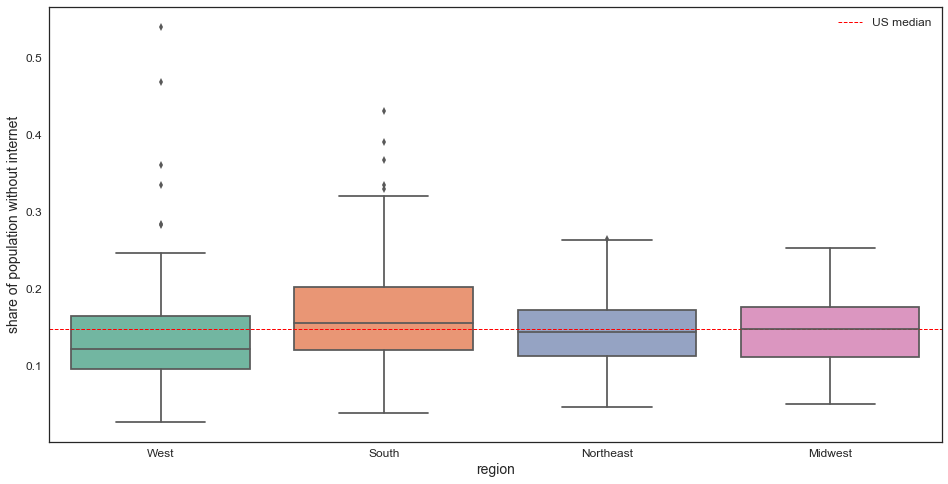

In [666]:
plt.figure(figsize=(16,8))
sns.boxplot(x="region", y="percent_no_internet", data=master, palette="Set2")
US_median = plt.axhline(master.percent_no_internet.median(),
                        color='red', linestyle='--', linewidth=1, label='US median')
plt.legend(handles=[US_median],fontsize=12)
plt.xlabel('region',fontsize=14)
plt.ylabel('share of population without internet',fontsize=14)
plt.tick_params(axis='both',labelsize=12)

The above claims are visually supported by the following map of all 50 states plus Washington, D.C., with several Southern states (together with New Mexico and Arizona in the West) having the highest share of population with no internet access (coloured in dark red).

In [667]:
no_internet_state = master.groupby(['state_code'])[['percent_no_internet']].median()
no_internet_state.columns = ['state_median_no_net']
no_internet_state = no_internet_state.reset_index().sort_values(by=['state_median_no_net'], ascending=False)
no_internet_state['text'] = no_internet_state['state_code'] + ': ' + round((no_internet_state['state_median_no_net']*100),2).astype(str) + "%"

data1 = [ dict(
        type='choropleth',
        autocolorscale = True,
        locations = no_internet_state['state_code'].tolist(),
        z = no_internet_state['state_median_no_net'].tolist(),
        text = no_internet_state['text'],
        hoverinfo = 'text',
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "median %")
        ) ]
   
layout = dict(
        title = 'Percentage of population without internet<br>(Hover for detailed information)',
        geo = dict(
            scope='usa',
            projection=dict(type='albers usa'),),
             )

fig = dict(data=data1, layout=layout)
py.iplot(fig)

In [668]:
print(f'US-wide share of people without internet (median): {round(np.median(master.percent_no_internet),4)}')
print(f'US-wide share of people without internet (mean): {round(np.mean(master.percent_no_internet),4)}')

US-wide share of people without internet (median): 0.1471
US-wide share of people without internet (mean): 0.1526


The following step creates a binary dependent variable `no_net_over_national_level` for our predictive models in the later stages of this project. 

A county has a value 1 if the median of its share of digitally unconnected lies above the national median level and 0 if it is below. This will ensure class balance of obervations in the regressions.

In [669]:
threshold_national = master.percent_no_internet.median()

# Creating dependent variable for the predictive model:
master['no_net_over_national_level'] = 0
master['no_net_over_national_level'][(master['percent_no_internet'] > threshold_national)] = 1

print(master.no_net_over_national_level.value_counts())

1    410
0    410
Name: no_net_over_national_level, dtype: int64


It seems that New Mexico is the state with highest proportion of digitally unconnected (> 25%). A closer look at this state reveals that all New Mexican counties contained in the dataset exhibit an unconnectedness rate higher than the national median. New Mexico is followed by Louisiana, Mississippi and Alabama.

On the other side of the spectrum, we find Colorado, Vermont and Utah, all with rates below 10%.

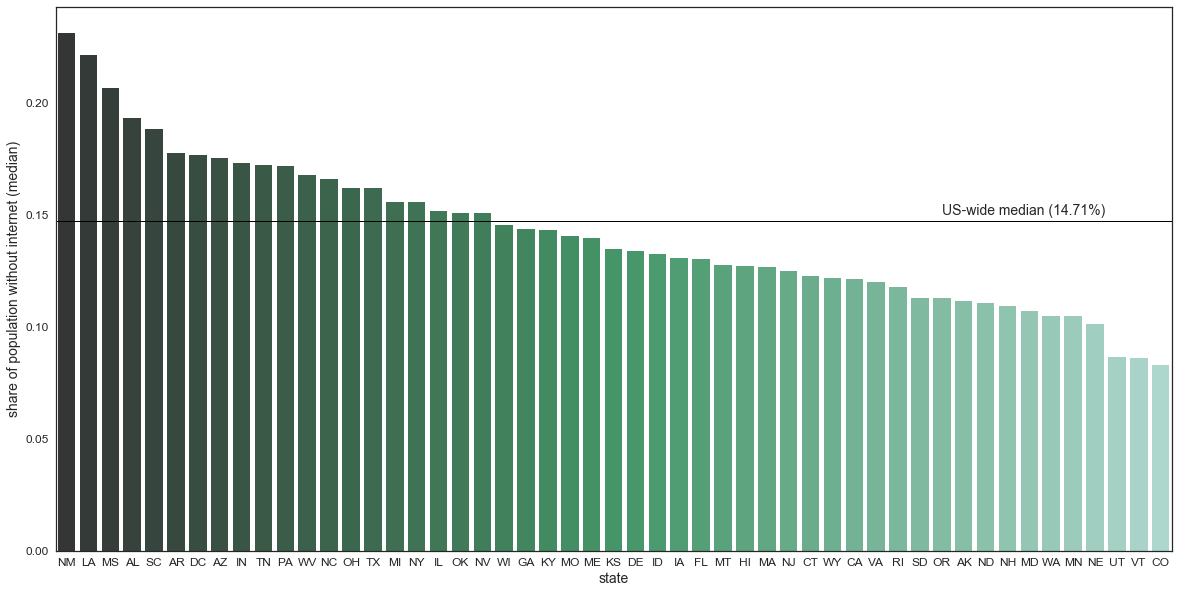

In [670]:
plt.figure(figsize=(20,10))

sns.barplot(x ='state_code', y='state_median_no_net',data = no_internet_state,palette="BuGn_d")
plt.axhline(master.percent_no_internet.median(), color='black',linewidth=1)
plt.annotate('US-wide median (14.71%)', xy=(40, 0.15), fontsize=14)

plt.xlabel('state',fontsize=14)
plt.ylabel('share of population without internet (median)',fontsize=14)
plt.tick_params(axis='both',labelsize=12)

In [671]:
# Combining the 'master' dataframe with state unconnectedness levels
master = pd.merge(master, no_internet_state, on='state_code',how="right")

In [672]:
newmex = master.loc[master['state_code'].str.contains('NM')]
newmex = newmex[['county','lon','lat','percent_no_internet']]
print(newmex)
newmex['percent_no_internet'] = round((newmex['percent_no_internet']*100),2)
newmex['popup'] = newmex['county'] + ': ' + (newmex['percent_no_internet']).astype(str) + '%'

                county         lon        lat  percent_no_internet
476  Bernalillo County -106.669065  35.054002             0.162354
477      Chaves County -104.469837  33.361604             0.283088
478    Doña Ana County -106.832182  32.350912             0.246096
479         Lea County -103.413271  32.795687             0.215842
480    McKinley County -108.255307  35.573732             0.468122
481       Otero County -105.781078  32.588776             0.173249
482    Sandoval County -106.882618  35.685073             0.160073
483    San Juan County -108.324578  36.511624             0.334648
484    Santa Fe County -105.966441  35.513722             0.186984
485    Valencia County -106.806582  34.716840             0.283989


The map below depicts differences in digital unconnectedness between the rural and urban areas in New Mexico. According to the local newspaper, <a href="http://www.santafenewmexican.com/life/tech/high-speed-internet-gaps-leave-rural-new-mexicans-lacking-a/article_a74dc838-a35f-5000-b7da-0aebd21f8897.html">'Santa Fe New Mexican'</a>, there are significant differences in internet accessibility across the state, caused particularly by high prices and low internet speed in rural areas compared to big cities like Albuquerque or Santa Fe. Furthermore, the two counties with the highest share of inhabitants without internet (McKinley and San Juan) are also home to the Navajo tribe reservation. As commented by <a href="digitalcommons.law.seattleu.edu/cgi/viewcontent.cgi?article=1164&context=ailj
">Donnellan (2017)</a>, out the 5.4 million Native Americans and Alaska Natives in the US, around one quarter live below the poverty line and are unable to afford internet access, which might also contribute to the high figures for the two counties.

In [673]:
map_osm = folium.Map(location=[34.5199, -105.8701], tiles='Stamen Toner', zoom_start=7)

for i in range(0,len(newmex)):
    folium.CircleMarker(
        location=[newmex.iloc[i]['lat'], newmex.iloc[i]['lon']],
        popup=newmex.iloc[i]['popup'],
        radius=newmex.iloc[i]['percent_no_internet'],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc').add_to(map_osm)

map_osm
# Zoom in for more detail
# Click on bubble for county name & information about the percentage of digitally unconnected

<div style="font-family:Helvetica">
<h3>Exploring correlations between attributes</h3>
</div>

The next subsection explores linear relationships between the attributes of our `master` dataframe. This step is vital for recognising potentially relevant factors for the predictive models.

As shown below, there is a number of attributes with high positive and negative correlation coefficients. We therefore investigate the actual coefficients in a correlation table to find atributes with strong link to the digital unconnectedness rate.

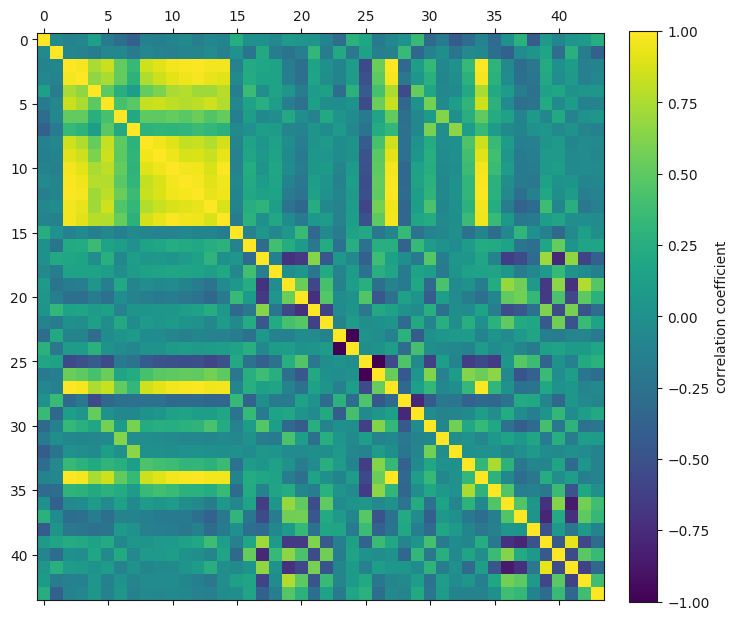

In [696]:
correlations = master.corr()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax,fraction=0.046, pad=0.04, label='correlation coefficient')

In [697]:
correlations

,lon,lat,P_total,P_white,P_black,P_asian,P_native,P_hawaiian,P_others,P_below_middle_school,P_some_high_school,P_high_school_equivalent,P_some_college,P_bachelor_and_above,P_below_poverty,median_age,gini_index,median_household_income,median_rent_per_income,percent_no_internet,with_disability,employment_rate,unemployment_rate,male,female,native_p_per,foreign_born_p_per,ethnicity,white_per,black_per,asian_per,native_per,hawaiian_per,others_per,edu,below_middle_school_per,some_high_school_per,high_school_per,some_college_per,bachelor_and_above_per,below_poverty_per,education_level,no_net_over_national_level,state_median_no_net
lon,1.000000,-0.054320,-0.104168,-0.068606,0.132779,-0.168883,-0.280450,-0.375879,-0.124056,-0.137603,-0.096755,-0.047241,-0.146114,-0.075354,-0.099790,0.243585,0.006900,0.000627,-0.060051,0.076285,0.044267,0.036360,-0.104425,-0.288725,0.288725,0.186654,-0.186654,-0.068081,0.013124,0.343773,-0.307306,-0.185861,-0.406672,-0.288274,-0.097653,-0.299962,0.002028,0.275864,-0.416317,0.080583,-0.079380,0.045992,0.090936,0.244896
lat,-0.054320,1.000000,-0.081087,-0.115944,-0.157080,-0.071740,-0.067080,-0.165592,-0.071789,-0.105721,-0.126938,-0.089206,-0.089257,-0.036896,-0.117663,0.009124,-0.220039,0.215803,-0.158108,-0.233225,-0.144388,0.327792,-0.161157,0.206746,-0.206746,0.141030,-0.141030,-0.123532,0.357106,-0.327458,-0.123880,-0.005796,-0.227768,-0.057513,-0.077424,-0.278107,-0.380461,-0.026723,0.038572,0.169131,-0.284644,0.266277,-0.151069,-0.376769
P_total,-0.104168,-0.081087,1.000000,0.971922,0.747189,0.838708,0.521726,0.340207,0.855374,0.911578,0.966224,0.977597,0.988319,0.961460,0.962629,-0.115311,0.225810,0.172653,0.155607,-0.153540,-0.261809,0.163468,0.005464,-0.093875,0.093875,-0.552827,0.552827,0.999819,-0.317735,0.124392,0.333877,-0.066939,0.008908,0.337359,0.998846,0.303865,-0.055461,-0.279501,-0.204664,0.230034,0.001028,0.107341,-0.131034,-0.101675
P_white,-0.068606,-0.115944,0.971922,1.000000,0.664573,0.745596,0.518515,0.289749,0.763149,0.844091,0.914558,0.951750,0.974050,0.935758,0.913047,-0.053713,0.231168,0.162942,0.151586,-0.144966,-0.262778,0.165141,-0.011932,-0.106968,0.106968,-0.502951,0.502951,0.972923,-0.200298,0.040272,0.272110,-0.082724,-0.022891,0.285313,0.970485,0.288654,-0.027720,-0.258950,-0.217066,0.209326,-0.022363,0.083983,-0.123896,-0.073632
P_black,0.132779,-0.157080,0.747189,0.664573,1.000000,0.498853,0.254333,0.109936,0.530272,0.607151,0.747170,0.781068,0.714326,0.711801,0.786508,-0.135321,0.367019,-0.020654,0.163333,0.040852,-0.158127,0.095998,0.138867,-0.288473,0.288473,-0.419840,0.419840,0.751101,-0.544993,0.524168,0.176098,-0.075256,-0.045080,0.215491,0.745206,0.216806,0.107834,-0.158880,-0.249171,0.145309,0.184148,0.017453,0.043310,0.061797
P_asian,-0.168883,-0.071740,0.838708,0.745596,0.498853,1.000000,0.415273,0.490670,0.820922,0.847392,0.801515,0.770177,0.803109,0.856748,0.767018,-0.071212,0.154280,0.250282,0.118461,-0.144779,-0.257480,0.134937,-0.011597,-0.024153,0.024153,-0.545781,0.545781,0.833139,-0.329803,0.021025,0.581087,-0.044490,0.116043,0.310482,0.844609,0.282535,-0.038646,-0.258646,-0.232588,0.220951,-0.048303,0.093850,-0.120761,-0.107843
P_native,-0.280450,-0.067080,0.521726,0.518515,0.254333,0.415273,1.000000,0.208973,0.507351,0.498016,0.523581,0.491458,0.550494,0.459467,0.529864,-0.135888,0.116599,-0.069212,-0.016019,0.210119,-0.021440,-0.116718,0.206371,0.032142,-0.032142,-0.170627,0.170627,0.519221,-0.258813,-0.065091,0.087586,0.629638,0.007176,0.250875,0.515036,0.231148,0.146205,-0.105474,0.082003,-0.064841,0.214939,-0.109634,0.016701,0.057851
P_hawaiian,-0.375879,-0.165592,0.340207,0.289749,0.109936,0.490670,0.208973,1.000000,0.295154,0.309052,0.304417,0.318295,0.364193,0.324723,0.288917,-0.048245,0.009217,0.120942,0.098766,-0.089141,-0.103113,0.036987,-0.025081,0.075926,-0.075926,-0.230576,0.230576,0.325140,-0.248067,-0.068588,0.596385,-0.018266,0.649770,0.117686,0.341522,0.108862,-0.052130,-0.100733,0.013040,0.044385,-0.055226,0.026089,-0.088086,-0

<div style="font-family:Helvetica">
<h3>Income</h3>
</div>

Median household income of a county is the first attribute of interest. The correlation coefficinet between `median_household_income` and `percent_no_internet`: -0.7067 suggest a strong negative relationship between the two attributes. 

Thus social exclusion leads to digital exclusion, which in turn leads to deeper inequalities

As depicted in the density plot below, Southern households peak at the lowest median income out of the four statistical regions (as defined by the <a href="http://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf">United States Census Bureau</a>). On the other hand, the West and Northeast appear to contain proportionally more high-income counties.

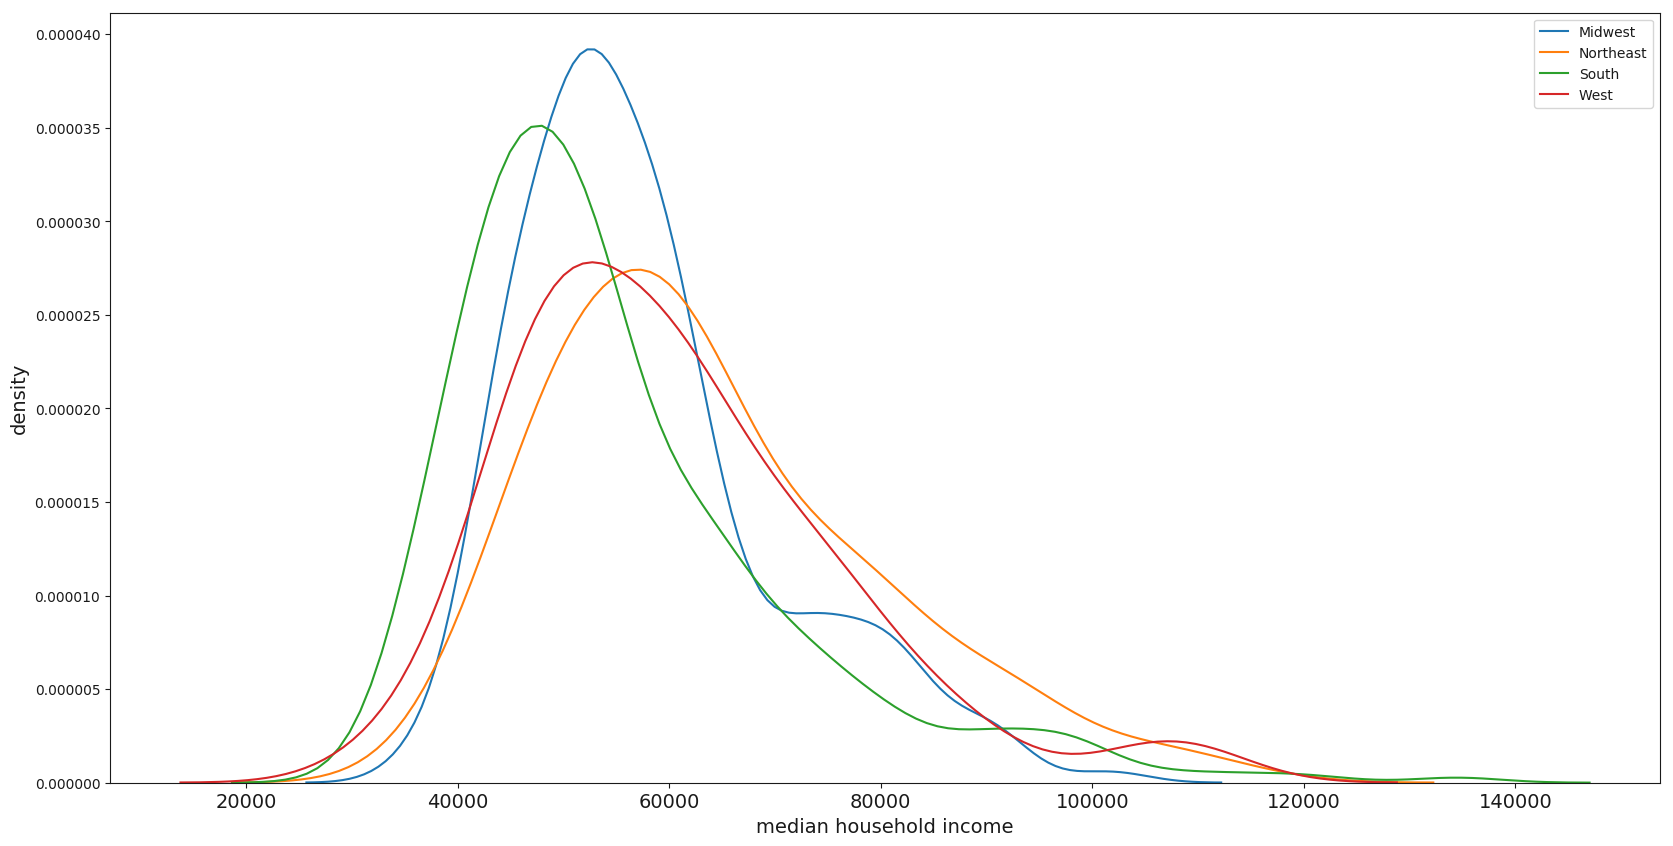

In [698]:
# Density plot of median household income by region
plt.figure(figsize=(20,10))

regions = master.groupby('region').median_household_income
for label, arr in regions:
    sns.kdeplot(arr, label=label)
    
plt.xlabel('median household income',fontsize=14)
plt.ylabel('density',fontsize=14)
plt.tick_params(axis='x',labelsize=14)

In the next step, we assess the household income distribution by nine income categories as defined by the US Census Bureau (<a href="https://www.census.gov/content/dam/Census/library/publications/2017/demo/P60-259.pdf">Income and Poverty in the United States 2016</a>). It is expected that the majority of counties in our sample will fall within the \$35,000-$150,000 range, in accordance to income distribution of US households from 2016:

<a href="https://www.statista.com/statistics/203183/percentage-distribution-of-household-income-in-the-us/" rel="nofollow"><img src="http://www.statista.com/graphic/1/203183/percentage-distribution-of-household-income-in-the-us.jpg" alt="Statistic: Household income distribution in the United States in 2016  | Statista" style="width: 70%; height: auto !important; max-width:1000px;-ms-interpolation-mode: bicubic;"/></a>

In [703]:
# Create income categories according to:

master['under_15000']=0
master['under_15000'][(master['median_household_income'] >= 0) & (master['median_household_income'] <= 14999)]=1

master['15000_24999']=0
master['15000_24999'][(master['median_household_income'] >= 15000) & (master['median_household_income'] <= 24999)]=1

master['25000_34999']=0
master['25000_34999'][(master['median_household_income'] >= 25000) & (master['median_household_income'] <= 34999)]=1

master['35000_49999']=0
master['35000_49999'][(master['median_household_income'] >= 35000) & (master['median_household_income'] <= 49999)]=1

master['50000_74999']=0
master['50000_74999'][(master['median_household_income'] >= 50000) & (master['median_household_income'] <= 74999)]=1

master['75000_99999']=0
master['75000_99999'][(master['median_household_income'] >= 75000) & (master['median_household_income'] <= 99999)]=1

master['100000_149999']=0
master['100000_149999'][(master['median_household_income'] >= 100000) & (master['median_household_income'] <= 149999)]=1

master['150000_199999']=0
master['150000_199999'][(master['median_household_income'] >= 150000) & (master['median_household_income'] <= 199999)]=1

master['200000_and_over']=0
master['200000_and_over'][(master['median_household_income'] >= 200000)]=1

In [704]:
state_income_class = master.groupby('state_code').agg({'under_15000':'sum',
                                                      '15000_24999':'sum',
                                                      '25000_34999':'sum',
                                                      '35000_49999':'sum',
                                                      '50000_74999':'sum',
                                                      '75000_99999':'sum',
                                                      '100000_149999':'sum',
                                                      '150000_199999':'sum',
                                                      '200000_and_over':'sum'})
print('Income class distribution of counties (%):')
state_income_class.sum()/820*100

Income class distribution of counties (%):


under_15000         0.000000
15000_24999         0.000000
25000_34999         0.731707
35000_49999        32.560976
50000_74999        53.048780
75000_99999        11.707317
100000_149999       1.951220
150000_199999       0.000000
200000_and_over     0.000000
dtype: float64

Most counties in our sample (~ 53%) fall in the \$50,000-\$74,999 range. Interestingly, there ano no counties with median household income below \$25,000 or above $150,000. We therefore disregard these categories from further analysis.

On a more granular level, we find that most states have the majority of counties in the mid-income-range of \$50,000-\$74,999 (see the graph below). Yet we find a number of exceptions such as Arizona and West Virginia, both with over 70% of counties in the \$35-50k range or Alaska and Maryland with majority of counties above the \$75k-level.

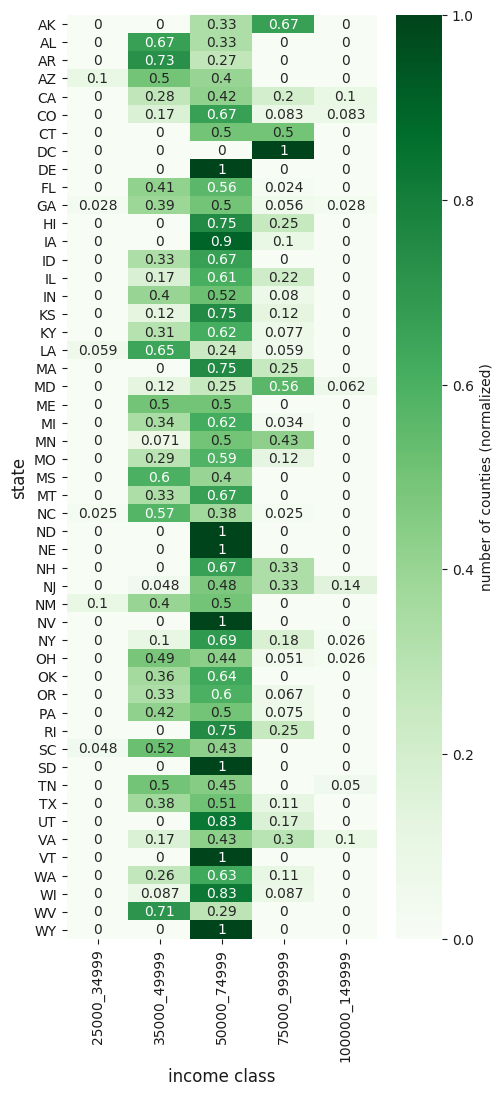

In [705]:
state_income_class = state_income_class.drop(['under_15000','15000_24999',
                                              '150000_199999', '200000_and_over'],axis=1)

master = master.drop(['under_15000','15000_24999', '150000_199999', '200000_and_over'],axis=1)

plt.figure(figsize=(5,12))
state_income_class = state_income_class.div(state_income_class.sum(axis=1), axis=0)
sns.heatmap(state_income_class, cmap='Greens', annot=True, cbar_kws={'label': 'number of counties (normalized)'})
plt.xlabel('income class', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('state',fontsize=12)
plt.tick_params(axis='x',labelsize=10)

The figure below depicts the negative relationship below median household income and the share of population without internet. Here, we find a number of low-income Southern and Western counties with high unconnectedness rates. In contrast, the observations in Midwestern and Northeastern US seem to have lower range of both income and percentage of unconnected.

Text(40.3962,0.5,'share of population without internet')

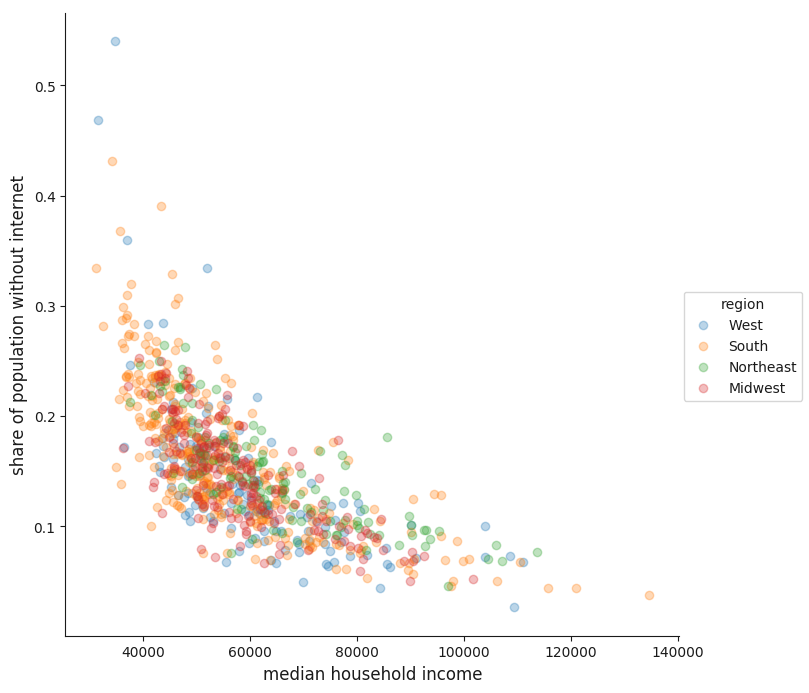

In [710]:
sns.lmplot('median_household_income', 'percent_no_internet', data=master, hue = 'region',
           size=7, fit_reg=False, scatter_kws={'alpha':0.3})
plt.xlabel('median household income', fontsize=12)
plt.ylabel('share of population without internet', fontsize=12)

This trend can be observed across all nine US divisions. Yet, the negative correlation between income and digital unconnectedness seems to be particularly strong in counties located in the Mountain division (i.e. in Arizona, Colorado, Idaho, Montana, Nevada, New Mexico, Utah, and Wyoming) and the West South Central division (Arkansas, Louisiana, Oklahoma, and Texas).

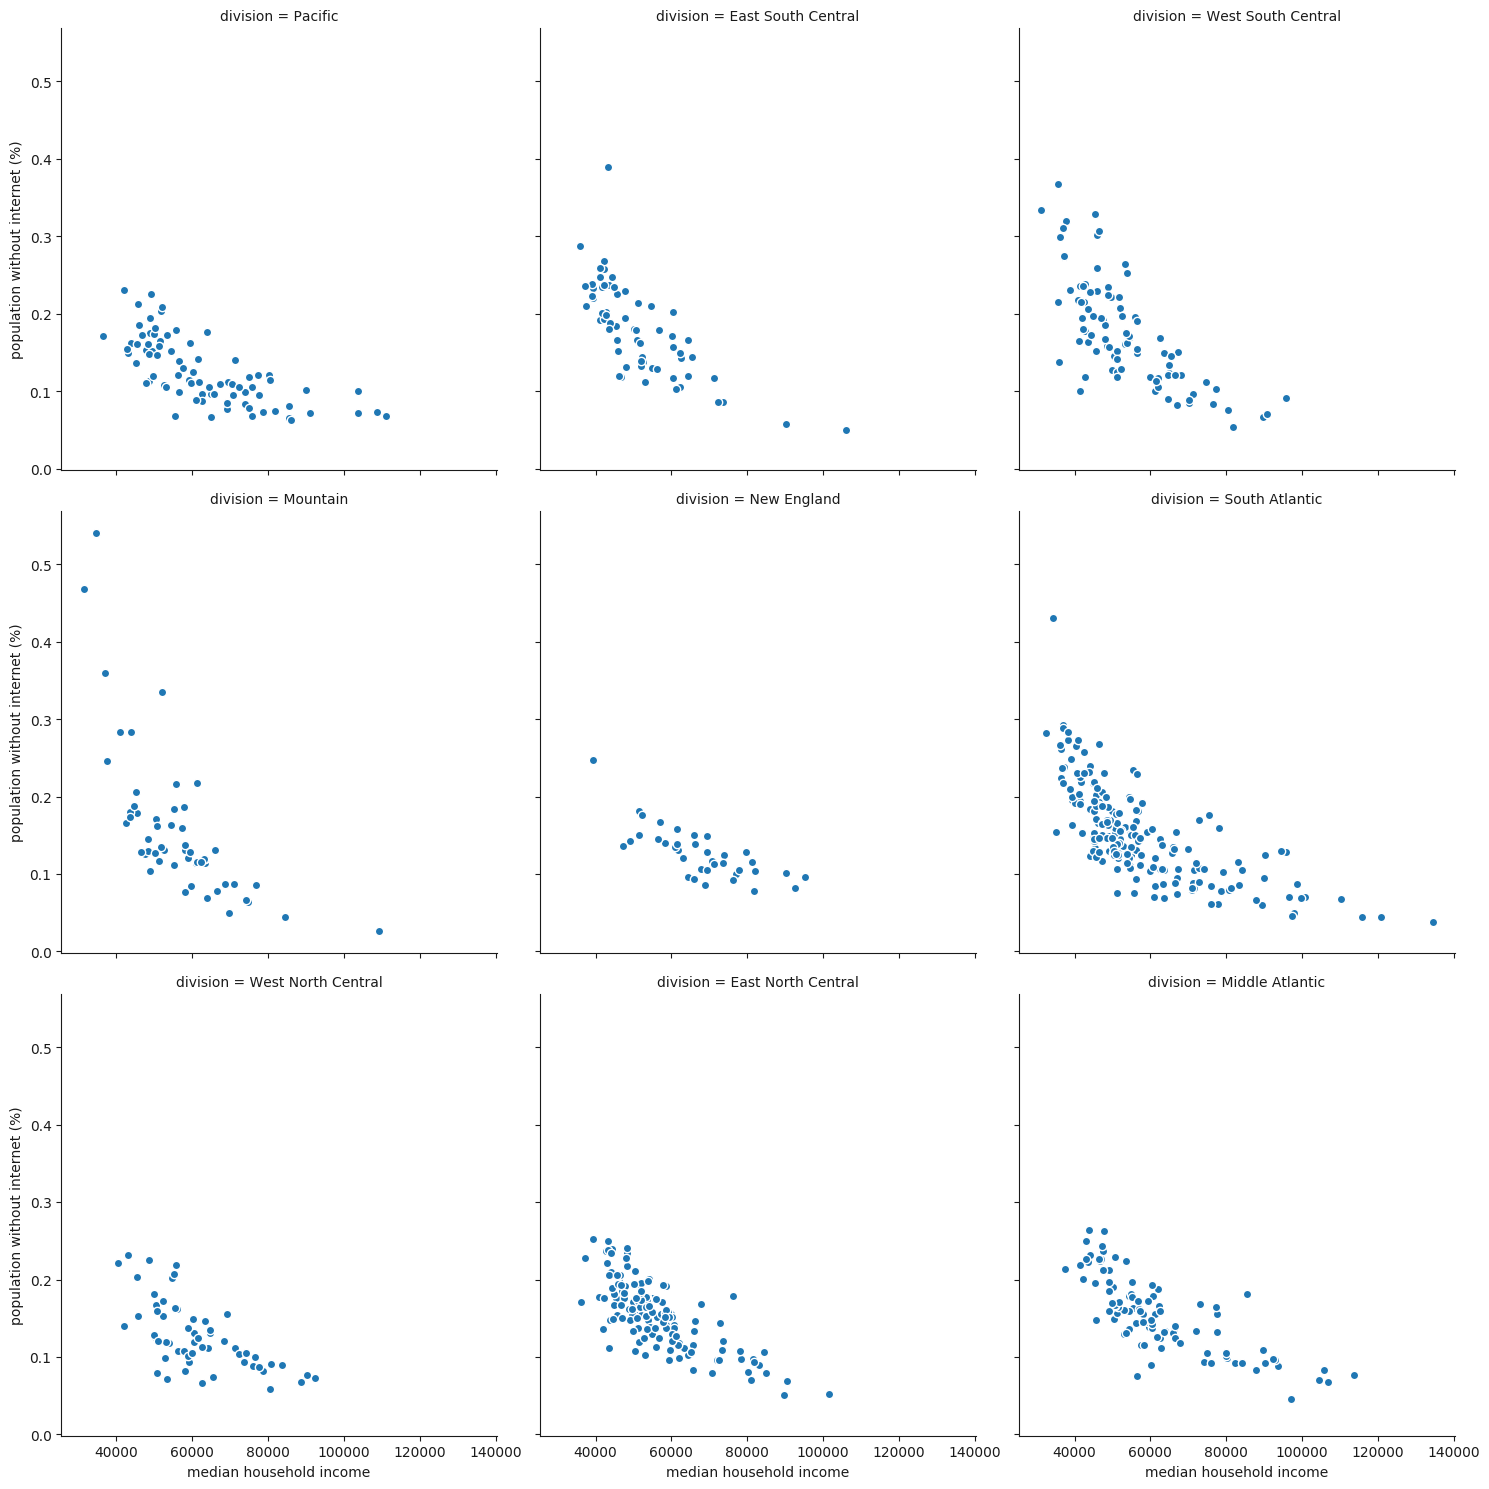

In [711]:
g = sns.FacetGrid(master, col="division",col_wrap=3, size=5)
g.map(plt.scatter, "median_household_income", "percent_no_internet", edgecolor="w")
g.set_axis_labels('median household income', 'population without internet (%)')

<div style="font-family:Helvetica">
<h3>Education</h3>
</div>

Education is another attribute strongly correlated with the share of digitally unconnected per county. With a correlation coefficient of over -0.71, it is also assumed to be a good predictor variable for the regression models within our project.

The following graph depicts the linear relationship between `education_level`and `percent_no_internet` as well as the value distributions of both attributes. As for education level, the data seems to be roughly evenly distributed with a slight left skew. 

Instead of overlapping, the plotting window is split in several hexbins, and the number of counties per hexbin is counted, with number of observations denoted by color. Thus, we identify that most counties have an education level of approx. 3.7-3.9 with internet unconnectedness rate of around 10-15%.

These findings support the findings mentioned in the 'Introduction' section about connection between educational attainment levels and internet unconnectedness.

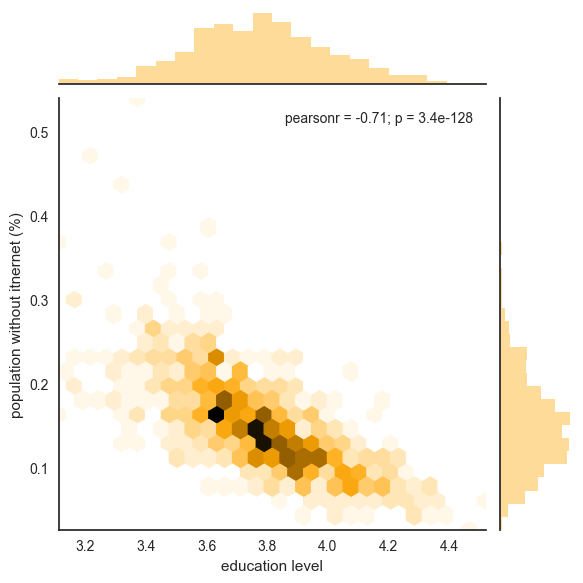

In [753]:
sns.set(style="white", color_codes=True)
sns.jointplot(x=master["education_level"], y=master["percent_no_internet"], kind='hex', 
              color="orange",size=6).set_axis_labels('education level', "population without itnernet (%)")

<div style="font-family:Helvetica">
<h3>Age</h3>
</div>

<a href="http://www.pewinternet.org/fact-sheet/internet-broadband/">Pew Research Center</a> has found that twith increasing age, the the use of Internet goes down. Another study from the Netherlands (<a href="https://www.tandfonline.com/doi/full/10.1080/01972243.2015.1069770?needAccess=true&instName=UCL+%28University+College+London%29">van Deursen & van Dijk, 2015</a>) also discusses that younger people have better Internet access then older population.

<a href="https://www.statista.com/statistics/266587/percentage-of-internet-users-by-age-groups-in-the-us/" rel="nofollow"><img src="http://www.statista.com/graphic/1/266587/percentage-of-internet-users-by-age-groups-in-the-us.jpg" alt="Statistic: Share of adults in the United States who use the internet in 2016, by age group | Statista" style="width: 60%; height: auto !important; max-width:1000px;-ms-interpolation-mode: bicubic;"/></a>

However, our investigated data do not support these claim - there does not seem to be a considerable relationship between median age in a county and internet unconnectedness rate.

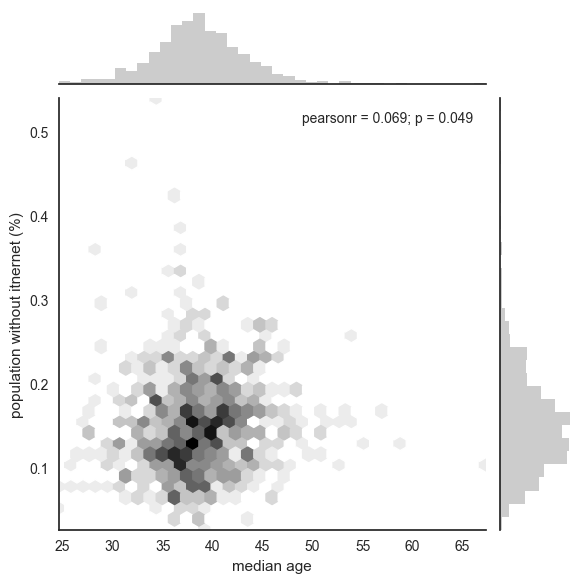

In [761]:
sns.set(style="white", color_codes=True)
sns.jointplot(x=master["median_age"], y=master["percent_no_internet"],
              size=6, kind="hex",  color="gray").set_axis_labels("median age", "population without itnernet (%)")

<div style="font-family:Helvetica">
<h3>Disability</h3>
</div>

<a href="https://www.tandfonline.com/doi/abs/10.1080/13691180600751298">Dobransky and Hargittai (2006)</a> comment that people with disabilities are less likely to live in households with computers, to use computers and to be online and are thus often affected by the so-called digital exclusion. The data indeed supports their findings - it is found that with increasing proportion of disabled population, the share of digitally unconnected population records a growing trend as well.

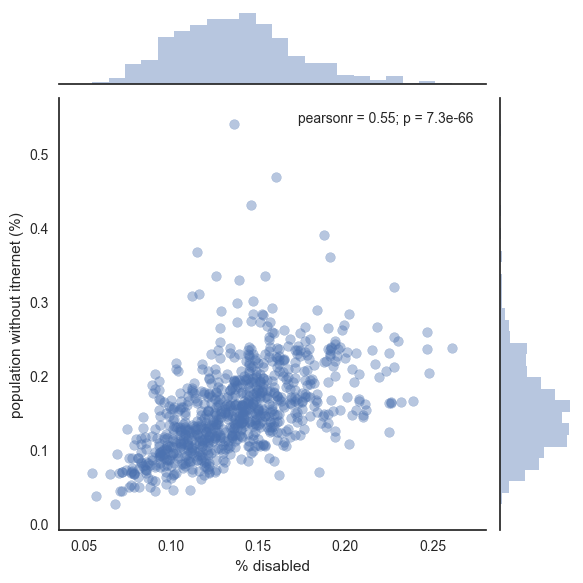

In [758]:
sns.set(style="white", color_codes=True)
sns.jointplot(x=master["with_disability"], y=master["percent_no_internet"],
              size=6, alpha=0.4).set_axis_labels("% disabled", "population without itnernet (%)")

<div style="font-family:Helvetica">
<h3>(Un-)Employment Rate</h3>
</div>

Text(0.5,0,'unemployment rate')

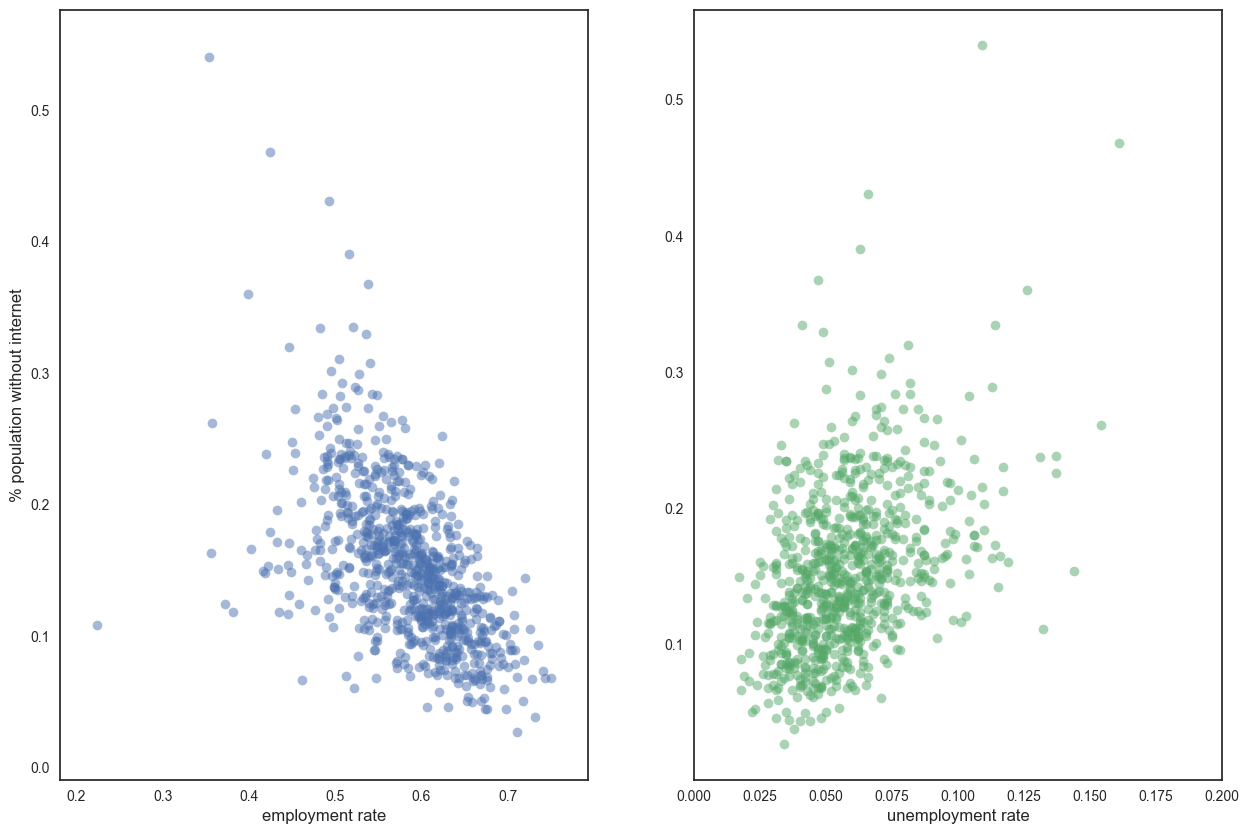

In [716]:
fig_employ, (ax1, ax2) = plt.subplots(ncols=2)
sns.regplot(x=master['employment_rate'], y=master['percent_no_internet'], 
            ax=ax1, fit_reg=False, scatter_kws={'alpha':0.5})

sns.regplot(x=master['unemployment_rate'], y=master['percent_no_internet'],
            ax=ax2, fit_reg=False, scatter_kws={'alpha':0.5})
ax2.set_xlim(0,0.2)
fig_employ.set_figheight(10)
fig_employ.set_figwidth(15)
ax1.set_ylabel('% population without internet', fontsize=12)
ax2.set_ylabel('')
ax1.set_xlabel('employment rate', fontsize=12)
ax2.set_xlabel('unemployment rate', fontsize=12)

<div style="font-family:Helvetica">
<h3>Ethnicity</h3>
</div>

A 1998 <a href="http://science.sciencemag.org/content/280/5362/390">study</a> by Donna L. Hoffman and Thomas P. Novak found significant disparities in Internet access between whites and African American. Almost 20 years later, it is assumed that the racial divide has diminished. 

Our dataset provides figures on the county population shares of six ethicities/races: whites, African Americans, Asians, Native Americans, Hawaiian and others. As can be seen in the overview below, with the exception of Hawaii and Washington, D.C., whites are the majority ethnical group in all US states.

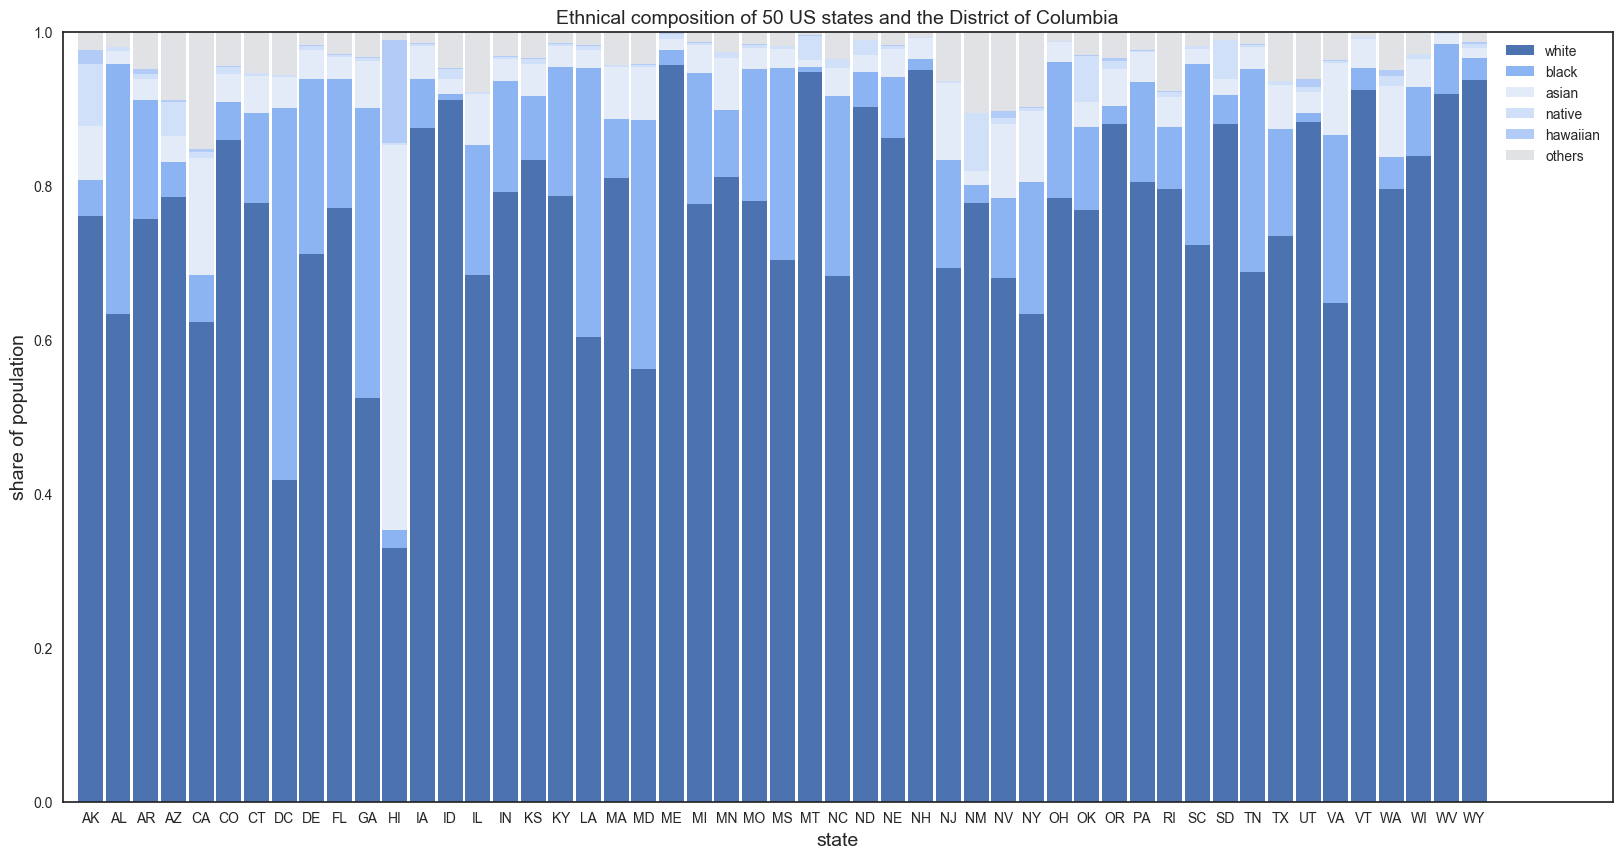

In [717]:
state_ethnic = master.groupby(['state_code'])[['P_white','P_black',
                                               'P_asian','P_native',
                                              'P_hawaiian','P_others','ethnicity']].sum()
state_ethnic['white_per'] = state_ethnic['P_white'] / state_ethnic['ethnicity']
state_ethnic['black_per'] = state_ethnic['P_black'] / state_ethnic['ethnicity']
state_ethnic['asian_per'] = state_ethnic['P_asian'] / state_ethnic['ethnicity']
state_ethnic['native_per'] = state_ethnic['P_native'] / state_ethnic['ethnicity']
state_ethnic['hawaiian_per'] = state_ethnic['P_hawaiian'] / state_ethnic['ethnicity']
state_ethnic['others_per'] = state_ethnic['P_others'] / state_ethnic['ethnicity']

state_ethnic = state_ethnic.reset_index()

plt.figure(figsize=(20,10))
configs = state_ethnic['state_code']
N = len(configs)
ind = np.arange(N)
width = 0.9

dataset1 = np.array(state_ethnic.white_per)
dataset2 = np.array(state_ethnic.black_per)
dataset3 = np.array(state_ethnic.asian_per)
dataset4 = np.array(state_ethnic.native_per)
dataset5 = np.array(state_ethnic.hawaiian_per)
dataset6 = np.array(state_ethnic.others_per)

p1 = plt.bar(ind, dataset1, width)
p2 = plt.bar(ind, dataset2, width,  bottom=dataset1, color="#8cb3f2")
p3 = plt.bar(ind, dataset3, width,  bottom=dataset1+dataset2, color="#e3ebf9")
p4 = plt.bar(ind, dataset4, width,  bottom=dataset1+dataset2+dataset3, color="#d1e0f9")
p5 = plt.bar(ind, dataset5, width,  bottom=dataset1+dataset2+dataset3+dataset4, color="#b2ccf7")
p6 = plt.bar(ind, dataset6, width,  bottom=dataset1+dataset2+dataset3+dataset4+dataset5,color="#e0e2e5")

plt.title('Ethnical composition of 50 US states and the District of Columbia', fontsize=14)
plt.ylim(0,1)
plt.xlim(-1,55)
plt.ylabel('share of population', fontsize=14)
plt.xlabel('state', fontsize=14)
plt.xticks(ind, configs)
plt.legend((p1[0], p2[0], p3[0], p4[0],p5[0],p6[0]), ('white', 'black','asian','native','hawaiian','others'))

<div style="font-family:Helvetica">
<h4>Principle Component Analysis</h4>
</div>

In order to reduce complexity of the racial attributes and thus, potentially, including in the predictive models, we use Principal Component Analysis (PCA).  The goal of PCA is to reduce dimensionality. This is done by converting observations of possibly correlated ethnicity-related variables into a set of values of linearly uncorrelated variables (i.e. principal components). In the end, only *n* components accounting for the most variability in the data are kept.

However, before running the PCA, it is important to treat missing values in our dataset. Overall, around 25% of counties do not included data on their ethnical composition of their populations. Therefore, we choose median single imputation (column-wise) to include these observations in the analysis.

In [718]:
# Defining method for imputation of missing data
imp = Imputer(missing_values='NaN', strategy='median', axis=0)

In [719]:
ethnicity = master[['Id2','white_per','black_per','asian_per','native_per','hawaiian_per','others_per',
                     'percent_no_internet']]
ehtnicity_imp = pd.DataFrame(imp.fit_transform(ethnicity))
ehtnicity_imp.columns = ethnicity.columns
ehtnicity_imp.corr()

,Id2,white_per,black_per,asian_per,native_per,hawaiian_per,others_per,percent_no_internet
Id2,1.000000,0.138368,-0.030159,-0.128775,-0.061992,-0.075763,-0.131607,0.020399
white_per,0.138368,1.000000,-0.772983,-0.443980,-0.206127,-0.225213,-0.383485,-0.100712
black_per,-0.030159,-0.772983,1.000000,0.002307,-0.088930,-0.070718,-0.011303,0.094724
asian_per,-0.128775,-0.443980,0.002307,1.000000,-0.069506,0.574585,0.216530,-0.289149
native_per,-0.061992,-0.206127,-0.088930,-0.069506,1.000000,-0.000889,0.028054,0.306571
hawaiian_per,-0.075763,-0.225213,-0.070718,0.574585,-0.000889,1.000000,0.017062,-0.052729
others_per,-0.131607,-0.383485,-0.011303,0.216530,0.028054,0.017062,1.000000,-0.034052
percent_no_internet,0.020399,-0.100712,0.094724,-0.289149,0.306571,-0.052729,-0.034052,1.000000


In [720]:
ehtnicity_imp = ehtnicity_imp.drop('percent_no_internet',axis=1)
ehtnicity_imp.head()

,Id2,white_per,black_per,asian_per,native_per,hawaiian_per,others_per
0,2020.0,0.690723,0.060171,0.101426,0.089371,0.028658,0.029652
1,2090.0,0.802792,0.046625,0.041202,0.078970,0.005348,0.025062
2,2170.0,0.914954,0.010802,0.011480,0.057825,0.001495,0.003445
3,1003.0,0.888773,0.092682,0.004501,0.006810,0.000000,0.007234
4,1015.0,0.831508,0.072364,0.025210,0.003690,0.000434,0.018970


In the next step, PCA is performed on standardised values and the set of four principal components, explaning more than 90% of variance, is chosen for later analysis. This way, the dimensionality was reduced from six to four.

([<matplotlib.axis.XTick at 0x11fa12f28>,
 <a list of 6 Text xticklabel objects>)

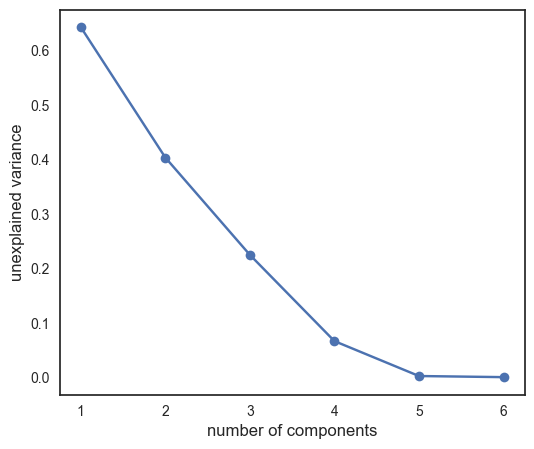

In [724]:
ethnic = list(ehtnicity_imp.columns.values)
ethnic.remove('Id2')
# Separating ethnicity
ehtnicity_imp_x = ehtnicity_imp.loc[:, ethnic].values
# Separating Id
ehtnicity_imp_y = ehtnicity_imp.loc[:,['Id2']].values

# Standardise values
ehtnicity_imp_stand = StandardScaler().fit_transform(ehtnicity_imp_x)

# Elbow method: In order to decide, how many principle components to use. 
def explained_var_plot(data,max_components):
    explained_var = PCA(n_components = max_components).fit(data).explained_variance_ratio_
    plt.plot(np.arange(max_components) + 1, 1 - np.cumsum(explained_var),marker='o')
plt.figure(figsize=(6,5))
    
# X-axis: number of PCA components
# Y-axis: amount of variance explained by different number of components
explained_var_plot(ehtnicity_imp_stand,6)
plt.xlabel('number of components',fontsize=12)
plt.ylabel('unexplained variance',fontsize=12)
plt.xticks(np.arange(1, 7, step=1))

In [725]:
pca_ethnic = PCA(n_components=4)
principalComponents_ethnic = pca_ethnic.fit_transform(ehtnicity_imp_stand)
principalDf_ethnic = pd.DataFrame(data = principalComponents_ethnic, columns = ['ethnic1','ethnic2',
                                                                                'ethnic3','ethnic4'])

finalPCA_ethnic = pd.concat([principalDf_ethnic, ethnicity['Id2']], axis = 1)
finalPCA_ethnic = finalPCA_ethnic.set_index('Id2').reset_index()
finalPCA_ethnic.head()

,Id2,ethnic1,ethnic2,ethnic3,ethnic4
0,02020,2.046710,1.966324,1.414919,1.814038
1,02090,0.008663,0.390996,1.508195,0.991148
2,02170,-1.292406,0.368015,1.016599,0.908852
3,01003,-1.028787,-0.173406,-0.225520,0.311329
4,01015,-0.521541,0.051559,-0.131472,0.060394


In [726]:
master_final = pd.merge(master, finalPCA_ethnic, on='Id2')

<div style="font-family:Helvetica;background-color:#3f5982">
<h1 ><font color="White">Regression Analysis</font></h1>
</div>

<div style="font-family:Helvetica">
<h3>Linear Regression</h3>
</div>

We use multiple linear regression to assess whether the continuous dependent variable `percent_no_internet`, i.e. the share of the digitally unconnected on county population can be predicted from a set of independent variables (i.e. predictors). In order to avoid offerfitting, feature selection and cross validation are implemented, too. 

In [51]:
master_final.columns

Index(['county', 'state_code', 'GEOID', 'lon', 'lat', 'P_total', 'P_white', 'P_black', 'P_asian', 'P_native', 'P_hawaiian', 'P_others', 'P_below_middle_school', 'P_some_high_school', 'P_high_school_equivalent', 'P_some_college', 'P_bachelor_and_above', 'P_below_poverty', 'median_age', 'gini_index', 'median_household_income', 'median_rent_per_income', 'percent_no_internet', 'state_name', 'region', 'division', 'Id2', 'with_disability', 'employment_rate', 'unemployment_rate', 'male', 'female',
       'native_p_per', 'foreign_born_p_per', 'ethnicity', 'white_per', 'black_per', 'asian_per', 'native_per', 'hawaiian_per', 'others_per', 'edu', 'below_middle_school_per', 'some_high_school_per', 'high_school_per', 'some_college_per', 'bachelor_and_above_per', 'below_poverty_per', 'education_level', 'text_x', 'no_net_over_national_level', 'state_median_no_net', 'text_y', '25000_34999', '35000_49999', '50000_74999', '75000_99999', '100000_149999', 'ethnic1', 'ethnic2', 'ethnic3', 'ethnic4'],
     

In [174]:
master_final_lin = master_final[['lon', 'lat', 'P_total', 'P_white',
                                 'P_black', 'P_asian', 'P_native', 'P_hawaiian',
                                 'P_others', 'P_below_middle_school', 'P_some_high_school',
                                 'P_high_school_equivalent', 'P_some_college', 'P_bachelor_and_above',
                                 'P_below_poverty', 'median_age', 'gini_index', 'median_household_income',
                                 'median_rent_per_income', 'percent_no_internet', 'with_disability',
                                 'employment_rate', 'unemployment_rate','male', 'female', 'native_p_per', 
                                 'foreign_born_p_per', 'ethnicity', 'white_per',
                                 'black_per', 'asian_per', 'native_per', 'hawaiian_per', 'others_per', 
                                 'below_middle_school_per', 'some_high_school_per', 'high_school_per',
                                 'some_college_per', 'bachelor_and_above_per','below_poverty_per','education_level',
                                 '25000_34999', '35000_49999', '50000_74999', '75000_99999', '100000_149999',
                                 'no_net_over_national_level', 
                                 'ethnic1', 'ethnic2', 'ethnic3', 'ethnic4']]
master_final_lin = pd.DataFrame(imp.fit_transform(master_final_lin))
master_final_lin.columns=['lon', 'lat', 'P_total', 'P_white',
                          'P_black', 'P_asian', 'P_native', 'P_hawaiian',
                          'P_others', 'P_below_middle_school', 'P_some_high_school',
                          'P_high_school_equivalent', 'P_some_college', 'P_bachelor_and_above',
                          'P_below_poverty', 'median_age', 'gini_index', 'median_household_income',
                          'median_rent_per_income', 'percent_no_internet', 'with_disability',
                          'employment_rate', 'unemployment_rate','male', 'female', 'native_p_per',
                          'foreign_born_p_per', 'ethnicity', 'white_per','black_per', 'asian_per', 
                          'native_per', 'hawaiian_per', 'others_per', 
                          'below_middle_school_per', 'some_high_school_per', 'high_school_per',
                          'some_college_per', 'bachelor_and_above_per','below_poverty_per','education_level',
                          '25000_34999', '35000_49999', '50000_74999', '75000_99999', 
                          '100000_149999','no_net_over_national_level',
                          'ethnic1', 'ethnic2', 'ethnic3', 'ethnic4']
master_final_lin['median_household_income_log'] = np.log(master_final_lin.median_household_income)
master_final_lin['median_rent_per_income']=master_final_lin['median_rent_per_income']/100

As a prerequisite stage of model building, we select only numerical attributes as possible candidates for independent variables in the OLS model. Furthermore, we define the percentage of county population to be our dependent variable.

In [288]:
X_linear = master_final_lin[['P_total', 
                          'median_age',
                          'gini_index',
                          'median_household_income_log',
                          'median_rent_per_income',
                          'with_disability',
                          'employment_rate','unemployment_rate',
                          'male', 'female', 
                          'native_p_per','foreign_born_p_per',
                          'education_level',
                          'below_poverty_per',
                          'ethnic1', 'ethnic2', 'ethnic3', 'ethnic4']]

y_lin = master_final_lin['percent_no_internet']

<div style="font-family:Helvetica">
<h3>Feature Selection</h3>
</div>

In order to avoid overfitting of our data, feautre selection is employed to select the most relevent attributes for the regression model. For this tasks, we use the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html">`f_regression`</a>  module for univariate linear regression tests, i.e. linear model for testing the individual effect of each of the regressors (through correlations between each regressor and the target variable). The resulting F-score is then used to select a smaller number of attributes for the OLS model.

In [419]:
selector_f = SelectKBest(f_regression, k='all')
selector_f.fit(X_linear,y_lin)
for n,s in zip(X_linear.columns,selector_f.scores_):
    print("F-score: %3.2f for feature %s " % (s,n))

F-score: 19.75 for feature P_total 
F-score: 3.89 for feature median_age 
F-score: 50.04 for feature gini_index 
F-score: 1036.92 for feature median_household_income_log 
F-score: 0.43 for feature median_rent_per_income 
F-score: 353.77 for feature with_disability 
F-score: 389.92 for feature employment_rate 
F-score: 174.87 for feature unemployment_rate 
F-score: 12.09 for feature male 
F-score: 12.09 for feature female 
F-score: 58.84 for feature native_p_per 
F-score: 58.84 for feature foreign_born_p_per 
F-score: 837.71 for feature education_level 
F-score: 609.42 for feature below_poverty_per 
F-score: 0.75 for feature ethnic1 
F-score: 48.36 for feature ethnic2 
F-score: 49.92 for feature ethnic3 
F-score: 30.72 for feature ethnic4 


Based on the results of the test, we select following predictors with the highest F-scores (and thus correlations with the dependent variable):
<br>
**`- median_household_income_log`**
<br>
**`- employment_rate`**
<br>
**`- with_disability`**
<br>
**`- education_level`**
<br>
**`- below_poverty_per`**

The first OLS model is then fitted with the chosen attributes:

In [424]:
X_lin = master_final_lin[['median_household_income_log',
                          'employment_rate',
                          'with_disability',
                          'education_level',
                          'below_poverty_per'
                     ]]
    
res_ols = sm.OLS(y_lin, sm.add_constant(X_lin)).fit()
print(res_ols.summary())

                             OLS Regression Results                            
Dep. Variable:     percent_no_internet   R-squared:                       0.645
Model:                             OLS   Adj. R-squared:                  0.643
Method:                  Least Squares   F-statistic:                     295.5
Date:                 Sun, 15 Apr 2018   Prob (F-statistic):          3.81e-180
Time:                         12:54:50   Log-Likelihood:                 1583.8
No. Observations:                  820   AIC:                            -3156.
Df Residuals:                      814   BIC:                            -3127.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const   

The R^2 of 0.645 suggests a good fit of our model. According to the above summary, all `median_household_income_log`, `education_level`, and `below_poverty_per` have significant effect on proportion of the digitally unconnected - growing income and education level are (respecitelly) associated with a decrease in percentage of population without internet access. On the other hand, the higher the share of people living below the poverty line, the higher the percentage of those without internet access in a county. On the other hand, the proportion of disabled inhabitants as well as the employment rate do not exhibit significant effect.

However, these results are likely affected by collinearity between predictors, which is a downside of the previously implemented F-score test. In fact, as can be seen in the overview below, all predictors exhibit a relatively high correlation coefficient of above +/-0.65. For this reason, we implement further techniques for feature eliminiation.

In [425]:
var_ols = pd.concat([X_lin, y_lin], axis = 1)
var_ols.corr()

,median_household_income_log,employment_rate,with_disability,education_level,below_poverty_per,percent_no_internet
median_household_income_log,1.000000,0.663580,-0.680126,0.679614,-0.810405,-0.747670
employment_rate,0.663580,1.000000,-0.714781,0.587633,-0.542363,-0.568158
with_disability,-0.680126,-0.714781,1.000000,-0.573823,0.428323,0.549463
education_level,0.679614,0.587633,-0.573823,1.000000,-0.536842,-0.711303
below_poverty_per,-0.810405,-0.542363,0.428323,-0.536842,1.000000,0.653406
percent_no_internet,-0.747670,-0.568158,0.549463,-0.711303,0.653406,1.000000


<div style="font-family:Helvetica">
<h3>Recursive feature elimination (<a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html">RFE</a> & <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html">RFECV</a>)</h3>
</div>

The goal of RFE is to select features by recursively considering smaller and smaller sets of features. This is done by repeatedly constructing a model (in our case a regression model) and choosing either the best or worst performing feature. The least important features are removed from current set of features, with the process being recursively repeated on the pruned set until the desired number of features to select is reached.

In the following subsection, we employ both RFECV for finding the optimal number of model variables through cross validation and RFE to select the actual variables.

As shown below, the power of the OLS model grows rapidly with each feature added, however, the gains level out after eight features/variables. Therefore, we use RFE to find the top eight attributes for the next model.

In [727]:
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_linear, y_lin)

trace1 = go.Scatter(x=list(range(1, len(selector.grid_scores_) + 1)),y=selector.grid_scores_)

layout1 = go.Layout(xaxis=dict(title="Number of features selected",
                              showgrid=False),
                   yaxis=dict(title="Cross validation score",
                              showgrid=False)
                  )
fig1 = go.Figure(data=[trace1], layout=layout1)
py.iplot(fig1)

In [296]:
linreg = LinearRegression()
rfe = RFE(linreg, 8)
rfe = rfe.fit(X_linear,y_lin)
print(rfe.support_ )
print(rfe.ranking_)

[False False False False  True False False False  True  True  True  True
 False  True False False False False]
[13 11  2  7  1  6  5  4  1  1  1  1  3  1 10 12  9  8]


RFE identifies the following features:
- `gini_index`
- `median_rent_per_income`
- `male`
- `female`
- `native_p_per`
- `foreign_p_per`
- `education_level`
- `below_poverty_per`

Yet, due to the obvious link between the features `male-female` and `native_p_per-foreign_p_per`, we remove one of the features respectivelly to avoid collinearity, thus resulting in a model with six variables:

In [429]:
X_lin = master_final_lin[['gini_index',
                          'median_rent_per_income',
                          'female', 
                          'native_p_per',
                          'education_level',
                          'below_poverty_per']]
    
res_ols = sm.OLS(y_lin, sm.add_constant(X_lin)).fit()
print(res_ols.summary())

                             OLS Regression Results                            
Dep. Variable:     percent_no_internet   R-squared:                       0.689
Model:                             OLS   Adj. R-squared:                  0.687
Method:                  Least Squares   F-statistic:                     300.0
Date:                 Sun, 15 Apr 2018   Prob (F-statistic):          3.05e-202
Time:                         13:37:22   Log-Likelihood:                 1638.1
No. Observations:                  820   AIC:                            -3262.
Df Residuals:                      813   BIC:                            -3229.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const             

All variables in the new model have a highly significant effect on the percentage of digitally unconnected people.

<u>Summary:</u>
- Increasing inequality (gini index) &#8594; higher Internet unconnectedness
- Higher share of income spent on rent &#8594; lower Internet unconnectedness
- Higher share of females on county population &#8594; higher Internet unconnectedness
- Higher share of US-born people on county population &#8594; more higher Internet unconnectedness
- Higher education level &#8594; lower Internet unconnectedness

<div style="font-family:Helvetica">
<h3>Making Predictions</h3>
</div>

Before making predictions about the proportion of digitally unconnected, we split the dataset into a training and a test set in an 80:20 ratio. The split is performed on a resampled dataframe in order to avoid any potential bias due to the order of entries in the `master` dataframe.

In [411]:
master_lin_resampled = sklearn.utils.resample(master_final_lin)

X_lin_sel = master_lin_resampled[['gini_index',
                          'median_rent_per_income',
                          'female', 
                          'native_p_per',
                          'education_level',
                          'below_poverty_per'
    
                     ]]

y_lin_sel = master_lin_resampled['percent_no_internet']

X_train, X_test, y_train, y_test = train_test_split(X_lin_sel, y_lin_sel, test_size=0.2,random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(656, 6) (656,)
(164, 6) (164,)


After training the model on 80% of data, we compare our predictions with the 20% test sample. The model yields accuracy of around 0.6813. The fit between the predictions and the actual values from the test sample is depicted below.

Score: 0.6812516449615467


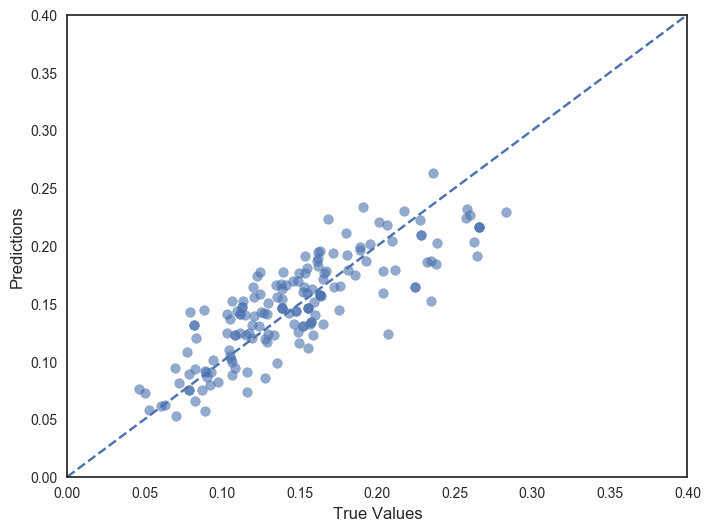

In [732]:
# Making predictions
lm = LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

# The line / model
plt.figure(figsize=(8,6))
plt.scatter(y_test, predictions, alpha = 0.6)
plt.plot([0, 0.4], [0, 0.4],'--')
plt.xlim([0.0, 0.4])
plt.ylim([0.0, 0.4])
plt.xlabel("True Values", fontsize=12)
plt.ylabel("Predictions",fontsize=12)
print("Score:", model.score(X_test, y_test))

Using 10-fold cross-validation, we find that the mean of the model accuracy is approx. 0.7015 (with standard deviation of 0.0457).

In [738]:
scores = cross_val_score(lm, X_train, y_train, cv=10)

print("Accuracy scores (cross-validation, k=10):", scores)
print("Mean:", scores.mean())
print("Standard deviation:", scores.std())

Accuracy scores (cross-validation, k=10): [0.69 0.73 0.71 0.72 0.69 0.73 0.75 0.61 0.63 0.76]
Mean: 0.7015443964442292
Standard deviation: 0.04566037230820176


<div style="font-family:Helvetica">
<h2>Logistic Regression</h2>
</div>

In the following subchapter, we discuss binomial logistic regression. The dependent variable `no_net_over_state_level` is binary and coded as 0 and 1, as discussed described ealier. In the first part, logit is used to determine which predictors are statistically significant, in terms of the effect on the dependent variable. Next, in a more Machine Learning approach, logistic regression is implemented to make predictions, i.e. whether a county will fall into the group of counties with digital unconnectedness rate *above* or *below* the national median level.

In [447]:
# Creating dataframe with all numerical attributes & the target variable 
master_log = master_final_lin[['P_total',
                               'median_age',
                               'gini_index',
                               'median_household_income_log',
                               'median_rent_per_income',
                               'with_disability',
                               'employment_rate','unemployment_rate',
                               'male', 'female',
                               'native_p_per','foreign_born_p_per',
                               'education_level',
                               'below_poverty_per',
                               'ethnic1', 'ethnic2', 'ethnic3', 'ethnic4',
                               'no_net_over_national_level']]

# Resampling
master_log_resampled = sklearn.utils.resample(master_log)

In [448]:
# Creating a set of X-variables & the y-variable
X_log = master_log_resampled[['P_total', 
                          'median_age',
                          'gini_index',
                          'median_household_income_log',
                          'median_rent_per_income',
                          'with_disability',
                          'employment_rate','unemployment_rate',
                          'male', 'female', 
                          'native_p_per','foreign_born_p_per',
                          'education_level',
                          'below_poverty_per',
                          'ethnic1', 'ethnic2', 'ethnic3', 'ethnic4']]

y_log = master_log_resampled['no_net_over_national_level']

Similarly to the previously built OLS model, we conduct recursive feature estimation to determine the optimal number of variables for the logit model. As shown in the graph below, the model power grows significantly for a model with up to four variables, after which it flattens out (and eventually dicreases). We therefore decide to select only four variables for the logistic regression model.

In [739]:
# RFECV
logreg = LogisticRegression()
selector = RFECV(logreg, step=1, cv=5)
selector = selector.fit(X_log, y_log)

trace = go.Scatter(x=list(range(1, len(selector.grid_scores_) + 1)),y=selector.grid_scores_)

layout = go.Layout(xaxis=dict(title="Number of features selected",
                              showgrid=False),
                   yaxis=dict(title="Cross validation score",
                              showgrid=False)
                  )

fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

In [348]:
# Feature selection (RFE)
rfe = RFE(logreg, 4)
rfe = rfe.fit(X_log,y_log)
print(rfe.support_)
print(rfe.ranking_)

[False False  True False False False False False False False  True False
  True  True False False False False]
[14 13  1  6  8  2  4  7  5  3  1 15  1  1 12 11  9 10]


With the help of RFE, `gini_index`, `native_p_per`, `education_level`, `below_poverty_per` are selected as predictor variables for the logistic regression model.

The output below provides the results of the logistic regression, with all independent variables being significant (i.e. coefficients significantly different from 0). As can be seen, an increase of all inequality, share of people living below the poverty line as well as the proportion of US-born population result in an expected increase in probability of the percentage of digitally unconnected inhabitants being above the national median. On the other hand, higher educational attainment is associated with a dicrease of chances of being above the national unconnectedness median level of 14.71%.

In [533]:
X_log_sel = master_log_resampled[['gini_index','native_p_per','education_level','below_poverty_per']]
result_log = sm.Logit(y_log,X_log_sel).fit()
print(result_log.summary())

Optimization terminated successfully.
         Current function value: 0.367632
         Iterations 8
                               Logit Regression Results                               
Dep. Variable:     no_net_over_national_level   No. Observations:                  820
Model:                                  Logit   Df Residuals:                      816
Method:                                   MLE   Df Model:                            3
Date:                        Mon, 16 Apr 2018   Pseudo R-squ.:                  0.4696
Time:                                14:39:41   Log-Likelihood:                -301.46
converged:                               True   LL-Null:                       -568.34
                                                LLR p-value:                2.293e-115
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
gini_index           27.8685  

In [461]:
# Fitting the Logit model
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log_sel, y_log,
                                                                    test_size=0.2,random_state=5)

logreg = LogisticRegression()
logreg.fit(X_train_log, y_train_log)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

For the purposes of this study, the performance of our logistic regression is assessed primarily by its predictive *accuracy*, which is defined as a fraction of correct predictions vs the total number of test data (i.e. 164 observations).

*Accuracy = (True Positive + True Negative) / (True Positive + True Negative + False Positve + False Negative)*

In [492]:
y_pred_log = logreg.predict(X_test_log)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logreg.score(X_test_log, y_test_log)))

Accuracy of logistic regression classifier on test set: 0.817


Using 10-fold cross validation to train the logistic model yields an average accuracy of aroud 81.5%, which is very close to the previously introduced accuracy score. We also find that 10-fold cross validation precision is 79.8%, whilst the average recall is higher at 85.3%.

The <a href="http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html"> scikit-learn documentation</a> defines Precision and Recall as follows:

- *Precision (P)*: number of true positives (TP) over the number of true positives plus the number of false positives (FP), i.e. P = TP / (TP + FP)

- *Recall (R)*: number of true positives (TP) over the number of true positives plus the number of false negatives (FN), i.e. R = TP / (TP + FN)

In [479]:
kfold = model_selection.KFold(n_splits=10, random_state=5)
results_logit_acc = model_selection.cross_val_score(logreg, X_train_log, y_train_log, cv=kfold, scoring='accuracy')
results_logit_pre = model_selection.cross_val_score(logreg, X_train_log, y_train_log, cv=kfold, scoring='precision')
results_logit_rec = model_selection.cross_val_score(logreg, X_train_log, y_train_log, cv=kfold, scoring='recall')

print("10-fold cross validation average accuracy: %.3f" % (results_logit_acc.mean()))
print("10-fold cross validation average precision: %.3f" % (results_logit_pre.mean()))
print("10-fold cross validation average recall: %.3f" % (results_logit_rec.mean()))

10-fold cross validation average accuracy: 0.815
10-fold cross validation average precision: 0.798
10-fold cross validation average recall: 0.853


<div style="font-family:Helvetica">
<h3>Confusion Matrix</h3>
</div>

Our logistic regression model accurately predicts 88% of counties with digital unconnectedness level *over* the national median value (i.e. True Positive) as well as 76% of counties *below* the national median value (i.e. False Positive). The False Negative rate is only 12%, i.e in nine cases, the model inaccurately predicts that a county's share of digitally unconnected population will be under the national median of 14.71% even though it is higher. Furthermore, we inaccuratelly estimate 21 counties as 'over the national level', while they in fact remain below the pre-defined threshold.

Normalized confusion matrix
[[0.76 0.24]
 [0.12 0.88]]


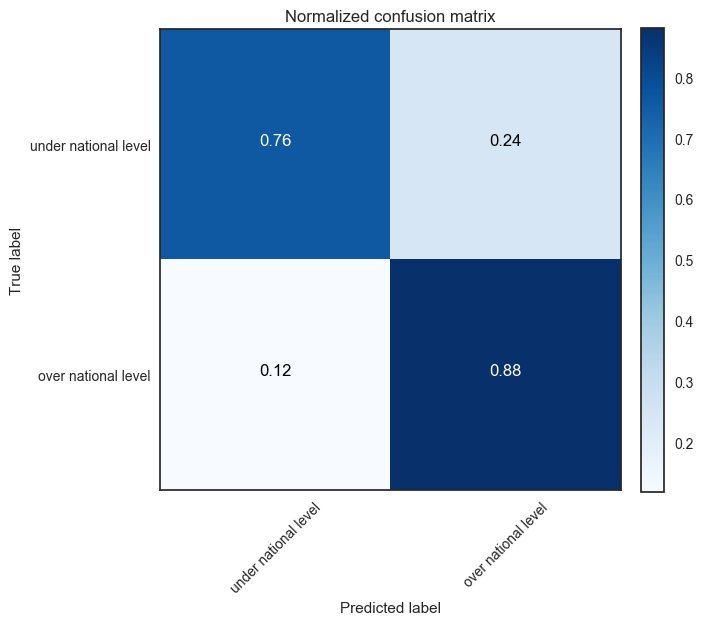

In [741]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["under national level","over national level"]    

# Plot non-normalized confusion matrix
#plt.figure(figsize=(8,8))
#plot_confusion_matrix(confusion_matrix_log, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(7,7))
plot_confusion_matrix(confusion_matrix_log, classes=class_names, normalize=True,
                      title='Normalised confusion matrix')
plt.show()

<div style="font-family:Helvetica">
<h3>ROC Curve</h3>
</div>

Finally, we plot the ROC curve, i.e. the *true positive rate (TPR)* (i.e. recall and thus the detection of counties with higher internet unconnectedness rate) against the *false positive rate (FPR)* (i.e. the probability of "false alarm" - incorrect prediction of higher digital unconnectedness rate) of our predictive model at various thresholds.

In our case, the area under the ROC curve is 0.82 and thus, we conclude that the implemented logit model can be considered to be good at predicting highly-unconnected counties and those with lower percentages (compared to national median levels).

In [742]:
logit_roc_auc = roc_auc_score(y_test_log, logreg.predict(X_test_log))
fpr, tpr, thresholds = roc_curve(y_test_log, logreg.predict_proba(X_test_log)[:,1])
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

NotFittedError: This LogisticRegression instance is not fitted yet

<div style="font-family:Helvetica;background-color:#3f5982">
<h1 ><font color="White">Conclusions</font></h1>
</div>